## ALL initial variables
FAVC - Frequent consumption of high caloric food\
FCVC - Frequency of consumption of vegetables\
NCP - Number of main meals\
CAEC - Consumption of food between meals\
SMOKE - Smoker or not\
CH2O - Consumption of water daily\
SCC - Calories consumption monitoring\
FAF - Physical activity frequency\
TUE - Time using technology devices\
CALC - Consumption of alcohol\
MTRANS - Transportation used\
NObeyesdad - Obesity level deducted

# 1. Import libraries

In [1]:
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint as sp_randint
from scipy.stats import uniform, randint
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
import xgboost as xgb
import optuna

# 2. Explore Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
print(train.shape)
print(test.shape)
print(train.info())
print(test.info())

(20758, 18)
(13840, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC     

In [3]:
print(train.head())
train.describe()

   id  Gender        Age    Height      Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998   81.669950                            yes   
1   1  Female  18.000000  1.560000   57.000000                            yes   
2   2  Female  18.000000  1.711460   50.165754                            yes   
3   3  Female  20.952737  1.710730  131.274851                            yes   
4   4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS           NObeyesdad  
0  0.976473

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [4]:
for col in train.select_dtypes(include='object'):
    unique_values = train[col].unique()
    print(f"Column: {col}: {unique_values}")

for col in test.select_dtypes(include='object'):
    unique_values = test[col].unique()
    print(f"Column: {col}: {unique_values}")

Column: Gender: ['Male' 'Female']
Column: family_history_with_overweight: ['yes' 'no']
Column: FAVC: ['yes' 'no']
Column: CAEC: ['Sometimes' 'Frequently' 'no' 'Always']
Column: SMOKE: ['no' 'yes']
Column: SCC: ['no' 'yes']
Column: CALC: ['Sometimes' 'no' 'Frequently']
Column: MTRANS: ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
Column: NObeyesdad: ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']
Column: Gender: ['Male' 'Female']
Column: family_history_with_overweight: ['yes' 'no']
Column: FAVC: ['yes' 'no']
Column: CAEC: ['Sometimes' 'Always' 'Frequently' 'no']
Column: SMOKE: ['no' 'yes']
Column: SCC: ['no' 'yes']
Column: CALC: ['Sometimes' 'no' 'Frequently' 'Always']
Column: MTRANS: ['Public_Transportation' 'Automobile' 'Walking' 'Bike' 'Motorbike']


In [5]:
train["CALC"].value_counts()

CALC
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64

In [6]:
test["CALC"].value_counts()

CALC
Sometimes     9979
no            3513
Frequently     346
Always           2
Name: count, dtype: int64

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

In [ ]:
# Drop rows with duplicates
train.drop_duplicates(inplace=True , keep="first")
test.drop_duplicates(inplace=True , keep="first")

# 3. Preprocessing

## 3.1 One hot encoding

In [7]:
X = train.drop(labels = ['id','NObeyesdad'], axis = 'columns')
y = train.NObeyesdad
test_X = test.drop(labels = ['id'], axis = 'columns')
# Mapping always to frequently since always is not in training set
test_X.CALC = test_X.CALC.replace('Always', 'Frequently')

In [8]:
print(X.columns)
print(test_X.columns)

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS'],
      dtype='object')
Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS'],
      dtype='object')


In [9]:
def encode_x(X):
    return pd.concat([pd.get_dummies(X.select_dtypes(include='object'),drop_first=True, dtype=int),
                      X.select_dtypes(exclude='object')],
                     axis='columns')

In [10]:
# training features with one-hot coding of categorical variables
dX = encode_x(X)
dX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Gender_Male                         20758 non-null  int32  
 1   family_history_with_overweight_yes  20758 non-null  int32  
 2   FAVC_yes                            20758 non-null  int32  
 3   CAEC_Frequently                     20758 non-null  int32  
 4   CAEC_Sometimes                      20758 non-null  int32  
 5   CAEC_no                             20758 non-null  int32  
 6   SMOKE_yes                           20758 non-null  int32  
 7   SCC_yes                             20758 non-null  int32  
 8   CALC_Sometimes                      20758 non-null  int32  
 9   CALC_no                             20758 non-null  int32  
 10  MTRANS_Bike                         20758 non-null  int32  
 11  MTRANS_Motorbike                    20758

In [11]:
dtest_X = encode_x(test_X)
dtest_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Gender_Male                         13840 non-null  int32  
 1   family_history_with_overweight_yes  13840 non-null  int32  
 2   FAVC_yes                            13840 non-null  int32  
 3   CAEC_Frequently                     13840 non-null  int32  
 4   CAEC_Sometimes                      13840 non-null  int32  
 5   CAEC_no                             13840 non-null  int32  
 6   SMOKE_yes                           13840 non-null  int32  
 7   SCC_yes                             13840 non-null  int32  
 8   CALC_Sometimes                      13840 non-null  int32  
 9   CALC_no                             13840 non-null  int32  
 10  MTRANS_Bike                         13840 non-null  int32  
 11  MTRANS_Motorbike                    13840

## 3.2 Save result function

In [12]:
def write_result_csv(test_X_id, test_y_arr, output_csv_path):
    # Convert the predicted labels to a Pandas Serie
    test_y = pd.Series(test_y_arr)
    # Concatenate the test_X_id and predicted labels along columns
    result = pd.concat([test_X_id, test_y], axis='columns')
    # Rename the columns to 'id' and 'NObeyesdad'
    result.columns = ['id','NObeyesdad']
    result.to_csv(output_csv_path, index=False)

## 3.3 Plot and label y

In [13]:
labels = pd.DataFrame(train['NObeyesdad'])
labels['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [14]:
labels_encoded = labels.copy(deep=True)

dict_conversion = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}

labels_encoded['NObeyesdad'] = labels_encoded['NObeyesdad'].map(dict_conversion)
labels_encoded.value_counts()

NObeyesdad
6             4046
5             3248
1             3082
4             2910
0             2523
3             2522
2             2427
Name: count, dtype: int64

C:\Users\vicky\AppData\Local\Temp\ipykernel_23560\341045427.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


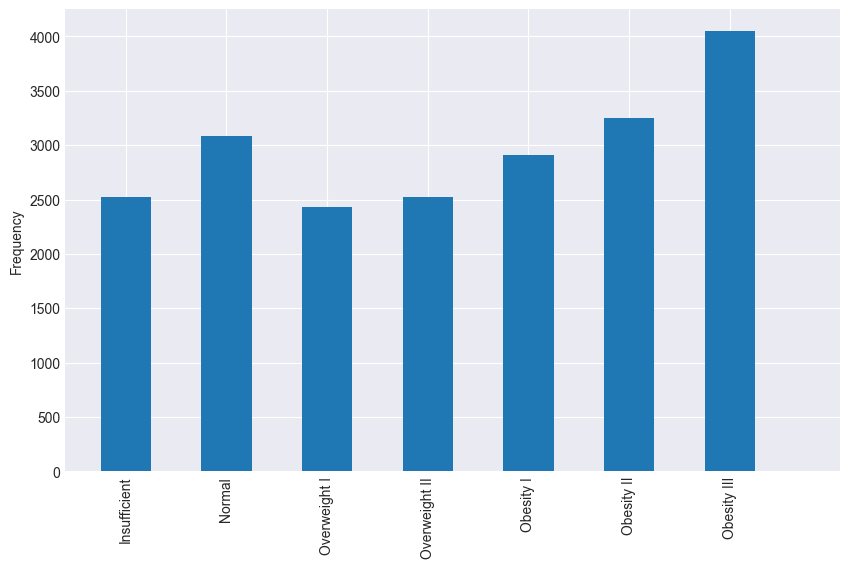

In [15]:
plt.style.use('seaborn-dark')

plt.figure(figsize=(10, 6))
plt.hist(labels_encoded, bins=np.arange(0, 8)-0.25, width=0.5, align='mid')
plt.grid()
plt.xticks(np.arange(0, 6.1),
           ['Insufficient', 'Normal', 'Overweight I', 'Overweight II', 'Obesity I', 'Obesity II', 'Obesity III'],
           rotation=90)
plt.ylabel('Frequency')
plt.show()

# 4. Feature Engineering
## 4.1 Fitting a logistic regression model

In [16]:
logit = linear_model.LogisticRegression(penalty= "l2",
                                        multi_class='auto',
                                        max_iter=100,
                                        solver='newton-cg')

# penalty='l2' specifies the regularization penalty. 'l2' stands for L2 regularization, also known as Ridge regularization.
# multi_class='auto' specifies the strategy for handling multinomial logistic regression. 'auto' automatically determines the appropriate strategy based on the data.
# max_iter=100 sets the maximum number of iterations for the optimization algorithm. This parameter controls the convergence of the algorithm.
# solver='newton-cg' specifies the optimization algorithm to use. 'newton-cg' stands for Newton-Conjugate Gradient, which is a method for finding the minimum of a function.

### Add six features as a simple model

In [26]:
feature_names = ['Gender_Male',
                 'family_history_with_overweight_yes',
                 'Age',
                 'Height',
                 'Weight',
                 'SMOKE_yes']
X_logit_simple = dX[feature_names]
l_simple = logit.fit(X_logit_simple, y)
l_simple.score(X_logit_simple, y)

0.82560940360343

### Plot feature importance

In [ ]:
def plot_importance(fit_model, data_X, y):
    model_fi = permutation_importance(fit_model, data_X, y)
    feature_name_map = {"FAVC": "Frequent consumption of high caloric food",
                        "FCVC": "Frequency of consumption of vegetables",
                        "NCP": "Number of main meals",
                        "CAEC": "Consumption of food between meals",
                        "SMOKE": "Smoker or not",
                        "CH2O":"Consumption of water daily",
                        "SCC": "Calories consumption monitoring",
                        "FAF": "Physical activity frequency",
                        "TUE": "Time using technology devices",
                        "CALC": "Consumption of alcohol",
                        "MTRANS": "Transportation used",
                        "NObeyesdad": "Obesity level deducted"}
    cols = data_X.columns
    new_cols = []
    for i in cols:
        new_i = i
        for k,v in feature_name_map.items():
            new_i = i.replace(k,v)
            if (new_i != i):
                break
        new_cols.append(new_i)
    df_features = pd.DataFrame(model_fi['importances_mean'], index=new_cols, columns=['Feature importances'])
    df_features = df_features.sort_values('Feature importances')

    df_features.plot(kind='barh')
    plt.grid()
    plt.xlabel('Feature importance')
    plt.show()

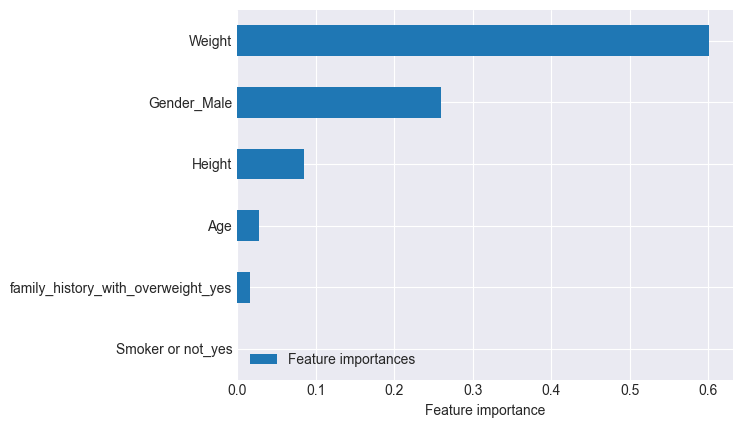

In [27]:
plot_importance(l_simple, X_logit_simple, y)

### Add height^3 feature

In [18]:
X_logit_h3 = X_logit_simple.copy()
X_logit_h3.loc[:,'Height_cubed'] = pd.Series(data = X_logit_simple.Height.pow(3))
# X_logit_h3 = X_logit_h3.drop(labels = ['Height'], axis = 'columns')
l_simple = logit.fit(X_logit_h3, y)
l_simple.score(X_logit_h3, y)

0.845601695731766

### Add height^3 / weight feature

In [19]:
X_logit_h3 = X_logit_simple.copy()
X_logit_h3.loc[:,'Weight_over_height_cubed'] = X_logit_h3.Weight / X_logit_simple.Height.pow(3)
l_simple = logit.fit(X_logit_h3, y)
l_simple.score(X_logit_h3, y)

0.8448309085653724

### Add BMI = weight/height^2

In [20]:
X_logit_h3 = X_logit_simple.copy()
X_logit_h3.loc[:,'BMI'] = X_logit_h3.Weight / X_logit_simple.Height.pow(2)
X_logit_h3 = X_logit_h3.drop(labels = ['Weight'], axis = 'columns')
l_simple = logit.fit(X_logit_h3, y)
l_simple.score(X_logit_h3, y)

0.846950573272955

### See feature importance

In [21]:
X_logit_h3.columns

Index(['Gender_Male', 'family_history_with_overweight_yes', 'Age', 'Height',
       'SMOKE_yes', 'BMI'],
      dtype='object')

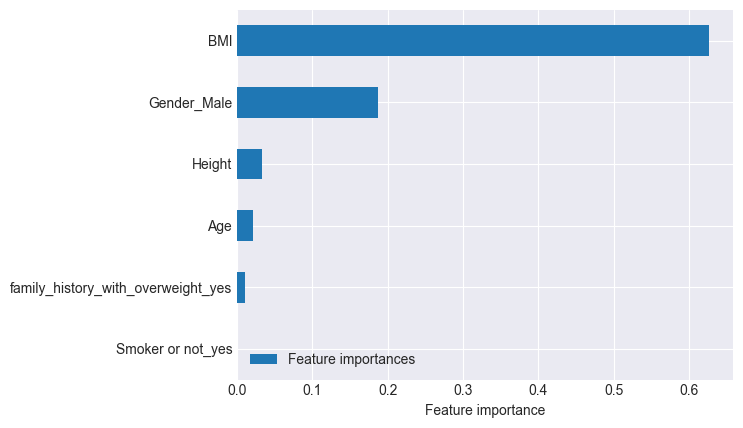

In [23]:
plot_importance(l_simple, X_logit_h3, y)

## 4.2 Logit model with all features

In [34]:
#logit with all initial features
l = logit.fit(dX, y)
l.score(dX, y)

0.8525387802293092

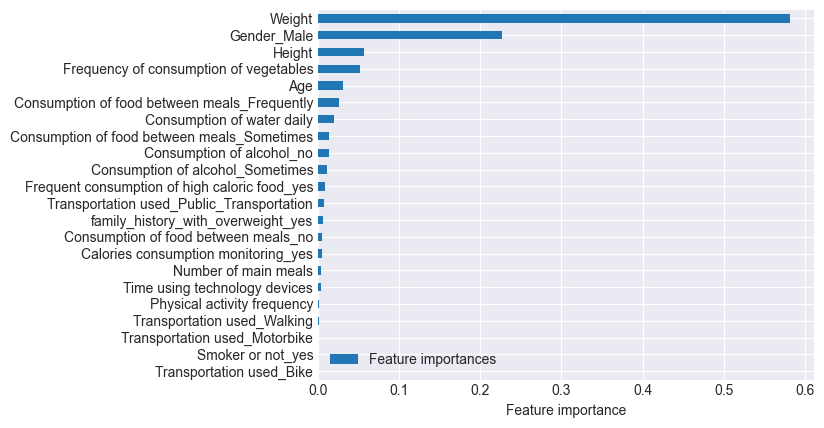

In [35]:
plot_importance(l, dX, y)

In [36]:
#logit with all initial features + height^3
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
l = logit.fit(new_X, y)
l.score(new_X, y)

0.8684362655361788

In [37]:
#logit with all initial features + Weight/Height.pow(3)
new_X = dX.copy()
new_X.loc[:,'Weight_over_height_cubed'] = new_X.Weight / new_X.Height.pow(3)
l = logit.fit(new_X, y)
l.score(new_X, y)

0.8678100009634839

In [38]:
#logit with all initial features + height^3 + FCVC^0.5
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
l = logit.fit(new_X, y)
l.score(new_X, y)

0.8684844397340784

In [39]:
#logit with all initial features + height^3 + FCVC^0.5 + Age^0.5
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'Age_pow1/2'] = new_X.Age.pow(0.5)
l = logit.fit(new_X, y)
l.score(new_X, y)

0.8702187108584643

In [40]:
#logit with all initial features + height^3 + FCVC^0.5 + Age^0.5 + CH20^2
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'Age_pow1/2'] = new_X.Age.pow(0.5)
new_X.loc[:,'CH2O_pow2'] = new_X.CH2O.pow(2)
l = logit.fit(new_X, y)
l.score(new_X, y)

0.8713267174101551

In [41]:
#logit with all initial features + height^3 + FCVC^0.5 + Age^0.5 + CH20^2 + CAEC_Sometimes^0.5
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'Age_pow1/2'] = new_X.Age.pow(0.5)
new_X.loc[:,'CH2O_pow2'] = new_X.CH2O.pow(2)
new_X.loc[:,'CAEC_Sometimes1/2'] = new_X.CAEC_Sometimes.pow(0.5)
l = logit.fit(new_X, y)
l.score(new_X, y)

0.8713748916080547

In [42]:
#logit with all initial features + height^3 + FCVC^0.5 + Age^0.5 + CH20^2 + CAEC_Sometimes^0.5 + FAF^0.5 - FAF
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'Age_pow1/2'] = new_X.Age.pow(0.5)
new_X.loc[:,'CH2O_pow2'] = new_X.CH2O.pow(2)
new_X.loc[:,'CAEC_Sometimes1/2'] = new_X.CAEC_Sometimes.pow(0.5)
new_X.loc[:,'FAF1/2'] = new_X.FAF.pow(0.5)
new_X = new_X.drop(labels = ['FAF'], axis = 'columns')
l = logit.fit(new_X, y)
l.score(new_X, y)

0.8715194142017535

In [43]:
#logit with all initial features + height^3 + FCVC^0.5 + Age^0.5 + CH20^2 + CAEC_Sometimes^0.5 + FAF^0.5 - FAF + NCP^0.5
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'Age_pow1/2'] = new_X.Age.pow(0.5)
new_X.loc[:,'CH2O_pow2'] = new_X.CH2O.pow(2)
new_X.loc[:,'CAEC_Sometimes1/2'] = new_X.CAEC_Sometimes.pow(0.5)
new_X.loc[:,'FAF1/2'] = new_X.FAF.pow(0.5)
new_X = new_X.drop(labels = ['FAF'], axis = 'columns')
new_X.loc[:,'NCP1/2'] = new_X.NCP.pow(0.5)

l = logit.fit(new_X, y)
l.score(new_X, y)

0.8722420271702476

In [44]:
#logit with all initial features + height^3 + FCVC^0.5 + Age^0.5 + CH20^2 + CAEC_Sometimes^0.5 + FAF^0.5 - FAF + NCP^0.5 + CALC_Sometimes^0.5
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'Age_pow1/2'] = new_X.Age.pow(0.5)
new_X.loc[:,'CH2O_pow2'] = new_X.CH2O.pow(2)
new_X.loc[:,'CAEC_Sometimes1/2'] = new_X.CAEC_Sometimes.pow(0.5)
new_X.loc[:,'FAF1/2'] = new_X.FAF.pow(0.5)
new_X = new_X.drop(labels = ['FAF'], axis = 'columns')
new_X.loc[:,'NCP1/2'] = new_X.NCP.pow(0.5)
new_X.loc[:,'CALC_Sometimes1/2'] = new_X.CALC_Sometimes.pow(1/2)

l = logit.fit(new_X, y)
l.score(new_X, y)

0.8723383755660469

In [45]:
#logit with all initial features + height^3 + FCVC^0.5 + Age^0.5 + CH20^2 + CAEC_Sometimes^0.5 + FAF^0.5 - FAF + NCP^0.5 + CALC_Sometimes^0.5 + MTRANS_Bike^0.5
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'Age_pow1/2'] = new_X.Age.pow(0.5)
new_X.loc[:,'CH2O_pow2'] = new_X.CH2O.pow(2)
new_X.loc[:,'CAEC_Sometimes1/2'] = new_X.CAEC_Sometimes.pow(0.5)
new_X.loc[:,'FAF1/2'] = new_X.FAF.pow(0.5)
new_X = new_X.drop(labels = ['FAF'], axis = 'columns')
new_X.loc[:,'NCP1/2'] = new_X.NCP.pow(0.5)
new_X.loc[:,'CALC_Sometimes1/2'] = new_X.CALC_Sometimes.pow(1/2)
new_X.loc[:,'MTRANS_Bike1/2'] = new_X.MTRANS_Bike.pow(0.5)
l = logit.fit(new_X, y)
l.score(new_X, y)

0.8723865497639465

In [46]:
#logit with all initial features + height^3 + FCVC^0.5 + Age^0.5 + CH20^2 + CAEC_Sometimes^0.5 + FAF^0.5 - FAF + NCP^0.5 + CALC_Sometimes^0.5 + MTRANS_Bike^0.5 + TUE^2
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'Age_pow1/2'] = new_X.Age.pow(0.5)
new_X.loc[:,'CH2O_pow2'] = new_X.CH2O.pow(2)
new_X.loc[:,'CAEC_Sometimes1/2'] = new_X.CAEC_Sometimes.pow(0.5)
new_X.loc[:,'FAF1/2'] = new_X.FAF.pow(0.5)
new_X = new_X.drop(labels = ['FAF'], axis = 'columns')
new_X.loc[:,'NCP1/2'] = new_X.NCP.pow(0.5)
new_X.loc[:,'CALC_Sometimes1/2'] = new_X.CALC_Sometimes.pow(1/2)
new_X.loc[:,'MTRANS_Bike1/2'] = new_X.MTRANS_Bike.pow(0.5)
new_X.loc[:,'TUE2'] = new_X.TUE.pow(2)
l = logit.fit(new_X, y)
l.score(new_X, y)

0.874265343482031

In [47]:
#logit with all initial features + height^3 + FCVC^0.5 + Age^0.5 + CH20^2 + CAEC_Sometimes^0.5 + FAF^0.5 - FAF + NCP^0.5 + CALC_Sometimes^0.5 + MTRANS_Bike^0.5 + TUE^2 + family_history_with_overweight_yes^0.5
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'Age_pow1/2'] = new_X.Age.pow(0.5)
new_X.loc[:,'CH2O_pow2'] = new_X.CH2O.pow(2)
new_X.loc[:,'CAEC_Sometimes1/2'] = new_X.CAEC_Sometimes.pow(0.5)
new_X.loc[:,'FAF1/2'] = new_X.FAF.pow(0.5)
new_X = new_X.drop(labels = ['FAF'], axis = 'columns')
new_X.loc[:,'NCP1/2'] = new_X.NCP.pow(0.5)
new_X.loc[:,'CALC_Sometimes1/2'] = new_X.CALC_Sometimes.pow(1/2)
new_X.loc[:,'MTRANS_Bike1/2'] = new_X.MTRANS_Bike.pow(0.5)
new_X.loc[:,'TUE2'] = new_X.TUE.pow(2)
new_X.loc[:,'family_history_with_overweight_yes1/2'] = new_X.family_history_with_overweight_yes.pow(0.5)

l = logit.fit(new_X, y)
l.score(new_X, y)

0.8743135176799306

In [54]:
#logit with all initial features + height^3 + FCVC^0.5 + Age^0.5 + CH20^2 + CAEC_Sometimes^0.5 + FAF^0.5 - FAF + NCP^0.5 + CALC_Sometimes^0.5 + MTRANS_Bike^0.5 + TUE^2 + family_history_with_overweight_yes^0.5 +BMI
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'Age_pow1/2'] = new_X.Age.pow(0.5)
new_X.loc[:,'CH2O_pow2'] = new_X.CH2O.pow(2)
new_X.loc[:,'CAEC_Sometimes1/2'] = new_X.CAEC_Sometimes.pow(0.5)
new_X.loc[:,'FAF1/2'] = new_X.FAF.pow(0.5)
new_X = new_X.drop(labels = ['FAF'], axis = 'columns')
new_X.loc[:,'NCP1/2'] = new_X.NCP.pow(0.5)
new_X.loc[:,'CALC_Sometimes1/2'] = new_X.CALC_Sometimes.pow(1/2)
new_X.loc[:,'MTRANS_Bike1/2'] = new_X.MTRANS_Bike.pow(0.5)
new_X.loc[:,'TUE2'] = new_X.TUE.pow(2)
new_X.loc[:,'family_history_with_overweight_yes1/2'] = new_X.family_history_with_overweight_yes.pow(0.5)
new_X.loc[:,'BMI'] = new_X.Weight / new_X.Height.pow(2)

l = logit.fit(new_X, y)
l.score(new_X, y)

c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


0.8748434338568263

In [61]:
#logit with all initial features + height^3 + FCVC^0.5 + Age^0.5 + CH20^2 + CAEC_Sometimes^0.5 + FAF^0.5 - FAF + NCP^0.5 + CALC_Sometimes^0.5 + MTRANS_Bike^0.5 + TUE^2 + family_history_with_overweight_yes^0.5 +BMI - Height
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'Age_pow1/2'] = new_X.Age.pow(0.5)
new_X.loc[:,'CH2O_pow2'] = new_X.CH2O.pow(2)
new_X.loc[:,'CAEC_Sometimes1/2'] = new_X.CAEC_Sometimes.pow(0.5)
new_X.loc[:,'FAF1/2'] = new_X.FAF.pow(0.5)
new_X = new_X.drop(labels = ['FAF'], axis = 'columns')
new_X.loc[:,'NCP1/2'] = new_X.NCP.pow(0.5)
new_X.loc[:,'CALC_Sometimes1/2'] = new_X.CALC_Sometimes.pow(1/2)
new_X.loc[:,'MTRANS_Bike1/2'] = new_X.MTRANS_Bike.pow(0.5)
new_X.loc[:,'TUE2'] = new_X.TUE.pow(2)
new_X.loc[:,'family_history_with_overweight_yes1/2'] = new_X.family_history_with_overweight_yes.pow(0.5)
new_X.loc[:,'BMI'] = new_X.Weight / new_X.Height.pow(2)
new_X = new_X.drop(labels = ['Height'], axis = 'columns')

l = logit.fit(new_X, y)
l.score(new_X, y)

c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


0.8747470854610271

In [59]:
#logit with all initial features + height^3 + FCVC^0.5 + Age^0.5 + CH20^2 + CAEC_Sometimes^0.5 + FAF^0.5 - FAF + NCP^0.5 + CALC_Sometimes^0.5 + MTRANS_Bike^0.5 + TUE^2 + family_history_with_overweight_yes^0.5 +BMI - Weight
new_X = dX.copy()
new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'Age_pow1/2'] = new_X.Age.pow(0.5)
new_X.loc[:,'CH2O_pow2'] = new_X.CH2O.pow(2)
new_X.loc[:,'CAEC_Sometimes1/2'] = new_X.CAEC_Sometimes.pow(0.5)
new_X.loc[:,'FAF1/2'] = new_X.FAF.pow(0.5)
new_X = new_X.drop(labels = ['FAF'], axis = 'columns')
new_X.loc[:,'NCP1/2'] = new_X.NCP.pow(0.5)
new_X.loc[:,'CALC_Sometimes1/2'] = new_X.CALC_Sometimes.pow(1/2)
new_X.loc[:,'MTRANS_Bike1/2'] = new_X.MTRANS_Bike.pow(0.5)
new_X.loc[:,'TUE2'] = new_X.TUE.pow(2)
new_X.loc[:,'family_history_with_overweight_yes1/2'] = new_X.family_history_with_overweight_yes.pow(0.5)
new_X.loc[:,'BMI'] = new_X.Weight / new_X.Height.pow(2)
new_X = new_X.drop(labels = ['Weight'], axis = 'columns')

l = logit.fit(new_X, y)
l.score(new_X, y)

0.8744098660757298

## 4.3 Use SVM to make prediction

In [56]:
# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

In [57]:
# Fit the model on the training data
l = svm_classifier.fit(dX, y)
l.score(dX, y)

0.8705559302437614

In [62]:
# Fit the model on the new_X data
l = svm_classifier.fit(new_X, y)
l.score(new_X, y)

0.877685711532903

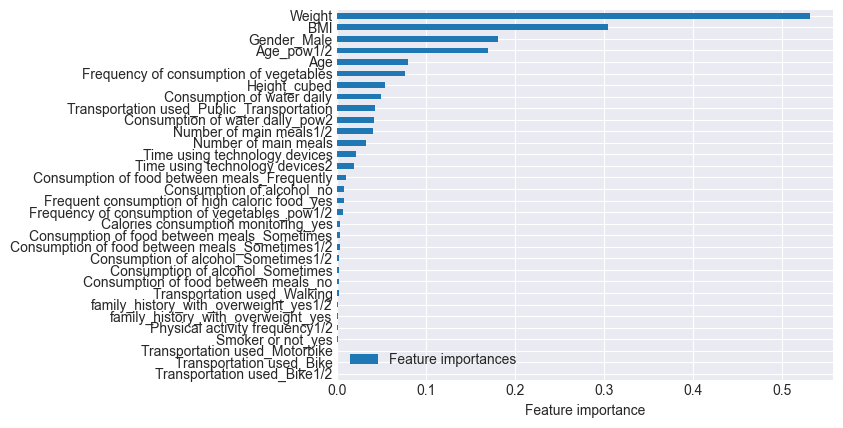

In [63]:
plot_importance(l, new_X, y)

## 4.4 Reducing number of features: all two same features only keep one

In [45]:
#describe current 31 features new model
new_X.columns

Index(['Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes', 'SCC_yes',
       'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking', 'Age', 'Height',
       'Weight', 'FCVC', 'NCP', 'CH2O', 'TUE', 'Height_cubed', 'FCVC_pow1/2',
       'Age_pow1/2', 'CH2O_pow2', 'CAEC_Sometimes1/2', 'FAF1/2', 'NCP1/2',
       'CALC_Sometimes1/2', 'MTRANS_Bike1/2', 'TUE2',
       'family_history_with_overweight_yes1/2'],
      dtype='object')

In [68]:
new_X[["family_history_with_overweight_yes","family_history_with_overweight_yes1/2",
       "MTRANS_Bike","MTRANS_Bike1/2",
       "CALC_Sometimes","CALC_Sometimes1/2",
       "CAEC_Sometimes","CAEC_Sometimes1/2"]].describe()

,family_history_with_overweight_yes,family_history_with_overweight_yes1/2,MTRANS_Bike,MTRANS_Bike1/2,CALC_Sometimes,CALC_Sometimes1/2,CAEC_Sometimes,CAEC_Sometimes1/2
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,0.819636,0.819636,0.001542,0.001542,0.725792,0.725792,0.844446,0.844446
std,0.384500,0.384500,0.039234,0.039234,0.446125,0.446125,0.362441,0.362441
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Test results with LGBM model

In [73]:
# Now test result
new_X = new_X.drop(labels = ['family_history_with_overweight_yes1/2','MTRANS_Bike1/2','CALC_Sometimes1/2','CAEC_Sometimes1/2'], axis = 'columns')

new_X_test = dtest_X.copy()
new_X_test.loc[:,'Height_cubed'] = new_X_test.Height.pow(3)
new_X_test.loc[:,'FCVC_pow1/2'] = new_X_test.FCVC.pow(0.5)
new_X_test.loc[:,'Age_pow1/2'] = new_X_test.Age.pow(0.5)
new_X_test.loc[:,'CH2O_pow2'] = new_X_test.CH2O.pow(2)
new_X_test.loc[:,'FAF1/2'] = new_X_test.FAF.pow(0.5)
new_X_test = new_X_test.drop(labels = ['FAF'], axis = 'columns')
new_X_test.loc[:,'NCP1/2'] = new_X_test.NCP.pow(0.5)
new_X_test.loc[:,'TUE2'] = new_X_test.TUE.pow(2)

assert all(new_X_test.columns == new_X.columns)
print('Number of train samples', len(new_X))
print('Number of train features', new_X.shape[1])
print('Number of test samples', len(new_X_test))
print('Number of test features', new_X_test.shape[1])




X_train, X_val, y_train, y_val = train_test_split(new_X, y, test_size=0.2, random_state=42)
lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train, y_train)
y_pred = lgbm_classifier.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

# Define a smaller grid of parameters or use distributions for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 8),
    'min_child_samples': sp_randint(5, 21),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgbm = LGBMClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

best_estimator = random_search.best_estimator_
test_y = best_estimator.predict(new_X_test)
write_result_csv(test.id, test_y, 'submission_newmodel28f.csv')
#Best Score: 0.9074433387638309

Number of train samples 20758
Number of train features 28
Number of test samples 13840
Number of test features 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3560
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 28
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
0.9051059730250481
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightG

## 4.5 Reducing number of features_2nd method: use ordinal encoding

In [77]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [78]:
X.select_dtypes(include='object').describe()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
count,20758,20758,20758,20758,20758,20758,20758,20758
unique,2,2,2,4,2,2,3,5
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
freq,10422,17014,18982,17529,20513,20071,15066,16687


In [28]:
def encode_x_v2(X):
    frequency_mapping = {'no': 1, 'Sometimes': 2, 'Frequently': 3, 'Always': 4}
    res = pd.concat([X.select_dtypes(exclude='object'), # all float features: age, height, weight, fcvc, ncp, ch2o, faf, tue
                      pd.get_dummies(X[['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', # binary features: gender, family_history_with_overweight, favc, smoke, scc
                        'SCC']], drop_first=True, dtype=int),
                      pd.Series(X.CAEC.map(frequency_mapping), name='CAEC_scalar'),
                      pd.Series(X.CALC.map(frequency_mapping), name='CALC_scalar'),
                      pd.Series(X.MTRANS.map({'Bike': 1, 'Walking': 2, 'Public_Transportation': 3, 'Motorbike': 4, 'Automobile': 5}), name='MTRANS_scalar')
                      ],
                     axis='columns')
    res.loc[:,'BMI'] = res.Weight / res.Height.pow(2)
    # res.loc[:,'Height_cubed'] = res.Height.pow(3)
    res.loc[:,'FCVC_pow1/2'] = res.FCVC.pow(0.5)
    res.loc[:,'FAF1/2'] = res.FAF.pow(0.5)
    res.loc[:,'TUE2'] = res.TUE.pow(2)
    res.loc[:,'CH2O_pow2'] = res.CH2O.pow(2)
    # res.loc[:,'MTRANS_scalar_2'] = res.MTRANS_scalar.pow(2)
    # res = res.drop(labels = ['MTRANS_scalar'], axis = 'columns')
    return res

### fitting models with new feature encodings

In [31]:
train_X = encode_x_v2(X)
l = logit.fit(new_X, y)
l.score(new_X, y)

c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


0.8678100009634839

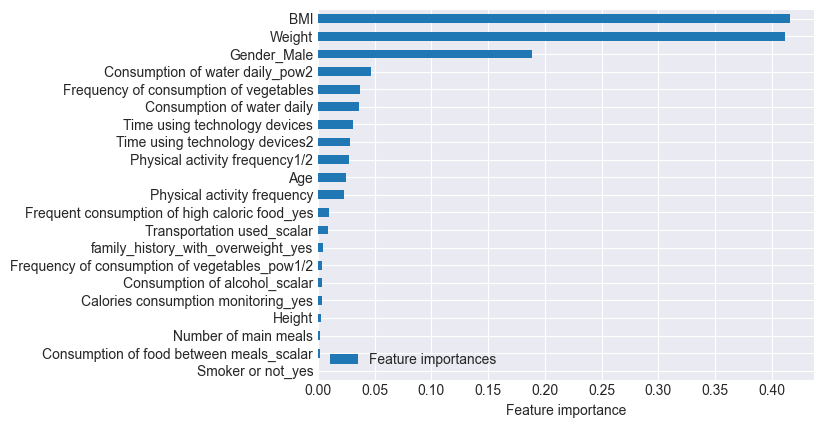

In [32]:
plot_importance(l, new_X, y)

In [85]:
l = logit.fit(train_X, y)
l.score(train_X, y)

c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


0.8482994508141439

In [87]:
s = svm_classifier.fit(train_X, y)
s.score(train_X, y)

0.8650640716832064

In [88]:
s = svm_classifier.fit(new_X, y)
s.score(new_X, y)

0.8724347239618461

In [89]:
new_X[['FCVC', 'FCVC_pow1/2']].describe()

,FCVC,FCVC_pow1/2
count,20758.000000,20758.000000
mean,2.445908,1.553869
std,0.533218,0.177201
min,1.000000,1.000000
25%,2.000000,1.414214
50%,2.393837,1.547203
75%,3.000000,1.732051
max,3.000000,1.732051


In [90]:
test_X = test.drop(labels = ['id'], axis = 'columns')
# Mapping always to frequently since always is not in training set
test_X.CALC = test_X.CALC.replace('Always', 'Frequently')


dtest_X = encode_x_v2(test_X)
new_X_test = dtest_X.copy()
new_X_test.loc[:,'Height_cubed'] = new_X_test.Height.pow(3)
new_X_test.loc[:,'FCVC_pow1/2'] = new_X_test.FCVC.pow(0.5)
new_X_test.loc[:,'FAF1/2'] = new_X_test.FAF.pow(0.5)
new_X_test.loc[:,'TUE2'] = new_X_test.TUE.pow(2)
new_X_test.loc[:,'CH2O_pow2'] = new_X_test.CH2O.pow(2)
new_X_test.loc[:,'MTRANS_scalar_2'] = new_X_test.MTRANS_scalar.pow(2)
new_X_test = new_X_test.drop(labels = ['MTRANS_scalar'], axis = 'columns')

assert all(new_X_test.columns == new_X.columns)
print('Number of train samples', len(new_X))
print('Number of train features', new_X.shape[1])
print('Number of test samples', len(new_X_test))
print('Number of test features', new_X_test.shape[1])


X_train, X_val, y_train, y_val = train_test_split(new_X, y, test_size=0.2, random_state=42)
lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train, y_train)
y_pred = lgbm_classifier.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

# Define a smaller grid of parameters or use distributions for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 8),
    'min_child_samples': sp_randint(5, 21),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgbm = LGBMClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

best_estimator = random_search.best_estimator_
test_y = best_estimator.predict(new_X_test)
write_result_csv(test.id, test_y, 'submission_newmodel21f.csv')

Number of train samples 20758
Number of train features 21
Number of test samples 13840
Number of test features 21
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3310
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 21
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
0.9039017341040463
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set 

## 4.6 Reducing number of features_3rd method: use one-hot emcoding + ordinal encoding

### dX+ ordinal encoding result

In [92]:
X = train.drop(labels = ['NObeyesdad'], axis = 'columns')
dX = encode_x(X)

train_X = encode_x_v2(X)
train_X = train_X[['id','CAEC_scalar','CALC_scalar','MTRANS_scalar']]

new_X = pd.merge(dX, train_X, on='id')
new_X = new_X.drop(labels = ['id'], axis = 'columns')


test_X = test.copy()
test_X.CALC = test_X.CALC.replace('Always', 'Frequently')
dtest_X = encode_x(test_X)

dtest_X2 = encode_x_v2(test_X)
dtest_X2 = dtest_X2[['id','CAEC_scalar','CALC_scalar','MTRANS_scalar']]

new_X_test = pd.merge(dtest_X, dtest_X2, on='id')
new_X_test = new_X_test.drop(labels = ['id'], axis = 'columns')


new_X.loc[:,'Height_cubed'] = new_X.Height.pow(3)
new_X.loc[:,'FCVC_pow1/2'] = new_X.FCVC.pow(0.5)
new_X.loc[:,'FAF1/2'] = new_X.FAF.pow(0.5)
new_X.loc[:,'TUE2'] = new_X.TUE.pow(2)
new_X.loc[:,'CH2O_pow2'] = new_X.CH2O.pow(2)
new_X.loc[:,'MTRANS_scalar_2'] = new_X.MTRANS_scalar.pow(2)
new_X = new_X.drop(labels = ['MTRANS_scalar'], axis = 'columns')



new_X_test.loc[:,'Height_cubed'] = new_X_test.Height.pow(3)
new_X_test.loc[:,'FCVC_pow1/2'] = new_X_test.FCVC.pow(0.5)
new_X_test.loc[:,'FAF1/2'] = new_X_test.FAF.pow(0.5)
new_X_test.loc[:,'TUE2'] = new_X_test.TUE.pow(2)
new_X_test.loc[:,'CH2O_pow2'] = new_X_test.CH2O.pow(2)
new_X_test.loc[:,'MTRANS_scalar_2'] = new_X_test.MTRANS_scalar.pow(2)
new_X_test = new_X_test.drop(labels = ['MTRANS_scalar'], axis = 'columns')

assert all(new_X_test.columns == new_X.columns)
print('Number of train samples', len(new_X))
print('Number of train features', new_X.shape[1])
print('Number of test samples', len(new_X_test))
print('Number of test features', new_X_test.shape[1])


X_train, X_val, y_train, y_val = train_test_split(new_X, y, test_size=0.2, random_state=42)
lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train, y_train)
y_pred = lgbm_classifier.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

# Define a smaller grid of parameters or use distributions for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 8),
    'min_child_samples': sp_randint(5, 21),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgbm = LGBMClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

best_estimator = random_search.best_estimator_
test_y = best_estimator.predict(new_X_test)
write_result_csv(test.id, test_y, 'submission_newmodel30f.csv')

Number of train samples 20758
Number of train features 30
Number of test samples 13840
Number of test features 30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3328
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 30
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
0.9017341040462428
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of

### Add features to dtest_X: Columns of training and test data must be the same

In [159]:
new_X_test = dtest_X.copy()
new_X_test.loc[:,'Height_cubed'] = new_X_test.Height.pow(3)
new_X_test.loc[:,'FCVC_pow1/2'] = new_X_test.FCVC.pow(0.5)
new_X_test.loc[:,'Age_pow1/2'] = new_X_test.Age.pow(0.5)
new_X_test.loc[:,'CH2O_pow2'] = new_X_test.CH2O.pow(2)
new_X_test.loc[:,'CAEC_Sometimes1/2'] = new_X_test.CAEC_Sometimes.pow(0.5)
new_X_test.loc[:,'FAF1/2'] = new_X_test.FAF.pow(0.5)
new_X_test = new_X_test.drop(labels = ['FAF'], axis = 'columns')
new_X_test.loc[:,'NCP1/2'] = new_X_test.NCP.pow(0.5)
new_X_test.loc[:,'CALC_Sometimes1/2'] = new_X_test.CALC_Sometimes.pow(1/2)
new_X_test.loc[:,'MTRANS_Bike1/2'] = new_X_test.MTRANS_Bike.pow(0.5)
new_X_test.loc[:,'TUE2'] = new_X_test.TUE.pow(2)
new_X_test.loc[:,'family_history_with_overweight_yes1/2'] = new_X_test.family_history_with_overweight_yes.pow(0.5)
assert all(new_X_test.columns == new_X.columns)
print('Number of train samples', len(new_X))
print('Number of train features', new_X.shape[1])
print('Number of test samples', len(new_X_test))
print('Number of test features', new_X_test.shape[1])

Number of train samples 20758
Number of train features 32
Number of test samples 13840
Number of test features 32


# 5. Training different models

## 5.1 Split new_X into training and validation sets

In [33]:
encoded_y = np.ravel(labels_encoded)
X_train, X_validation, y_train, y_validation = train_test_split(new_X, encoded_y,
                                                                test_size=0.2, 
                                                                random_state=42,
                                                                stratify=encoded_y)

## 5.2 Fit the data with baseline models

In [34]:
clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier(class_weight='balanced')
clf3 = LGBMClassifier(class_weight='balanced')
clf4 = XGBClassifier()

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3311
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 21
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [35]:
def evaluate_model(clf):
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_validation)
    train_score = np.mean(y_pred_train == y_train)
    validation_score = np.mean(y_pred_test == y_validation)

    print('Train score', round(train_score, 3))
    print('Test score', round(validation_score, 3))
    
    if train_score - validation_score > 0.05:
        print('Overfitting detected')
        
    print('===========================')

print('Random Forest')
evaluate_model(clf2)

print('LightGBM')
evaluate_model(clf3)

print('Gradient Boosting')
evaluate_model(clf1)

print('XGBoost')
evaluate_model(clf4)

Random Forest
Train score 1.0
Test score 0.9
Overfitting detected
LightGBM
Train score 0.982
Test score 0.9
Overfitting detected
Gradient Boosting
Train score 0.922
Test score 0.896
XGBoost
Train score 0.991
Test score 0.9
Overfitting detected


## 5.3 Use the LGBMClassifier from the LightGBM library to make predictions

In [176]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(new_X, y, test_size=0.2, random_state=42)

# Create an instance of the LGBMClassifier
lgbm_classifier = LGBMClassifier()

# Fit the model on the training data
lgbm_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = lgbm_classifier.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
accuracy

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3568
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 32
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625


0.9051059730250481

### Use LGBM cross-validated grid search and randomized search to find the best combination of parameters

In [177]:
# Define a smaller grid of parameters or use distributions for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 8),
    'min_child_samples': sp_randint(5, 21),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize LGBM classifier
lgbm = LGBMClassifier(random_state=42)

# Perform randomized search
random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3568
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 32
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [178]:
# Use the best estimator to make predictions
# test_new_X = dtest_X.copy()
# test_new_X.loc[:,'Height_cubed'] = test_new_X.Height.pow(3)
# test_new_X['Height_Weight_Interact'] = test_new_X['Height'] * test_new_X['Weight']

best_estimator = random_search.best_estimator_
test_y = best_estimator.predict(new_X_test)
write_result_csv(test.id, test_y, 'submission_907.csv')
# Submition score: 0.9168

## 5.4 Use a Random Forest classifier

In [179]:
# Define a smaller grid of parameters or use distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Perform randomized search
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)

# Get the best parameters and best score
best_params_rf = random_search_rf.best_params_
best_score_rf = random_search_rf.best_score_
print("Best Parameters (Random Forest):", best_params_rf)
print("Best Score (Random Forest):", best_score_rf)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
171 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
59 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\vicky\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.

Best Parameters (Random Forest): {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Best Score (Random Forest): 0.8908228509067365


## 5.5 Use XGBoost model

In [36]:

# Initialize LabelEncoder
# label_encoder = LabelEncoder()

# Fit LabelEncoder on the target variable and transform it
# y_train_encoded = label_encoder.fit_transform(y_train)
encoded_y = np.ravel(labels_encoded)
X_train, X_validation, y_train, y_validation = train_test_split(new_X, encoded_y,test_size=0.2,random_state=42,stratify=encoded_y)

# Now, y_train_encoded contains integer labels

# Define a parameter grid for tuning
param_dist = {
    'learning_rate': uniform(0.01, 0.3),  # Learning rate
    'n_estimators': randint(100, 500),  # Number of boosting rounds
    'max_depth': randint(3, 10),  # Maximum depth of a tree
    'min_child_weight': randint(1, 10),  # Minimum sum of instance weight needed in a child
    'subsample': uniform(0.6, 0.4),  # Subsample ratio of the training instance
    'colsample_bytree': uniform(0.6, 0.4),  # Subsample ratio of columns when constructing each tree
    'gamma': uniform(0, 1),  # Minimum loss reduction required to make a further partition on a leaf node
    'reg_alpha': uniform(0, 1),  # L1 regularization term on weights
    'reg_lambda': uniform(0, 1),  # L2 regularization term on weights
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Perform randomized search for hyperparameter tuning
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)

# Proceed with fitting the XGBoost model using the encoded target variable
random_search_xgb.fit(X_train, y_train)


# Get the best parameters and best score
best_params_xgb = random_search_xgb.best_params_
best_score_xgb = random_search_xgb.best_score_
print("Best Parameters:", best_params_xgb)
print("Best Score:", best_score_xgb)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'colsample_bytree': 0.706712405710114, 'gamma': 0.9766149558326529, 'learning_rate': 0.1333111039954694, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 323, 'reg_alpha': 0.9082658859666537, 'reg_lambda': 0.23956189066697242, 'subsample': 0.6579579488364892}
Best Score: 0.9087076808468791


In [212]:
# Skip this cell

# Predict using the best model obtained from RandomizedSearchCV
# test_new_X = dtest_X.copy()
# test_new_X.loc[:,'Height_cubed'] = test_new_X.Height.pow(3)
# test_new_X['Height_Weight_Interact'] = test_new_X['Height'] * test_new_X['Weight']

test_y_encoded = random_search_xgb.predict(new_X_test)
# Inverse transform the predicted labels to get the original target variable
label_encoder = LabelEncoder()
label_encoder.fit(y)
test_y_original = label_encoder.inverse_transform(test_y_encoded)
write_result_csv(test.id, test_y_original, 'submission_909.csv')
#Submition score: 0.2471

### Use best parameters XGB to predict test

In [213]:
# Previous model (previous simple model + height_weight_interation and height_cubed)
best_params_XGB = {'colsample_bytree': 0.7734082950322968, 
                   'gamma': 0.7440426429991154, 
                   'learning_rate': 0.08525815820399835, 
                   'max_depth': 4, 
                   'min_child_weight': 5,
                   'n_estimators': 417, 
                   'reg_alpha': 0.8359801205122058, 
                   'reg_lambda': 0.695974206093698, 
                   'subsample': 0.763581177765708}

# train the best model

clf = XGBClassifier(**best_params_XGB)
clf.fit(new_X, encoded_y)
predictions = clf.predict(new_X_test)

reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))

df_submission = pd.read_csv('sample_submission.csv')
df_submission['NObeyesdad'] = predictions
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

df_submission.to_csv('submission.csv', index=False)
# 0.91329

In [ ]:
# new model + previous parameter
best_params_XGB = {'colsample_bytree': 0.7734082950322968, 
                   'gamma': 0.7440426429991154, 
                   'learning_rate': 0.08525815820399835, 
                   'max_depth': 4, 
                   'min_child_weight': 5,
                   'n_estimators': 417, 
                   'reg_alpha': 0.8359801205122058, 
                   'reg_lambda': 0.695974206093698, 
                   'subsample': 0.763581177765708}

# train the best model

clf = XGBClassifier(**best_params_XGB)
clf.fit(new_X, encoded_y)
predictions = clf.predict(new_X_test)

reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))

df_submission = pd.read_csv('sample_submission.csv')
df_submission['NObeyesdad'] = predictions
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

df_submission.to_csv('submission.csv', index=False)
# Submition score: 0.91257

In [214]:
# new model + new parameter
best_params_XGB = {'colsample_bytree': 0.8066785029706267, 
                   'gamma': 0.6571113285001668, 
                   'learning_rate': 0.1407018696033673, 
                   'max_depth': 7, 
                   'min_child_weight': 7,
                   'n_estimators': 175, 
                   'reg_alpha': 0.5660372104940763, 
                   'reg_lambda': 0.15864644764249103, 
                   'subsample': 0.6480658591222569}

# train the best model

clf = XGBClassifier(**best_params_XGB)
clf.fit(new_X, encoded_y)
predictions = clf.predict(new_X_test)

reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))

df_submission = pd.read_csv('sample_submission.csv')
df_submission['NObeyesdad'] = predictions
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

df_submission.to_csv('submission.csv', index=False)
# Submition score: 0.91546

In [37]:
# new model 30 feature + new parameter
best_params_XGB = {'colsample_bytree': 0.7367518666865607, 
                   'gamma': 0.09179906581344188, 
                   'learning_rate': 0.03824709648056803, 
                   'max_depth': 8, 
                   'min_child_weight': 4,
                   'n_estimators': 303, 
                   'reg_alpha': 0.017161101831750236, 
                   'reg_lambda': 0.7633644230039109, 
                   'subsample': 0.9227651908203118}

# train the best model

clf = XGBClassifier(**best_params_XGB)
clf.fit(new_X, encoded_y)
predictions = clf.predict(new_X_test)

reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))

df_submission = pd.read_csv('sample_submission.csv')
df_submission['NObeyesdad'] = predictions
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

df_submission.to_csv('submission.csv', index=False)
# Submition score: 0.91835

NameError: name 'new_X_test' is not defined

## 5.6 Fine-tune the XGBoost Classifier, using Optuna

In [163]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 4, 10)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0, 1)
    
    print('Training the model with', X.shape[1], 'features')
    
    # XGBoost
    params = {'n_estimators': n_estimators,
              'learning_rate': learning_rate,
              'gamma': gamma,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'eval_metric':'mlogloss'}
        
    clf = XGBClassifier(**params)
    
    
    cv_results = cross_validate(clf, new_X, encoded_y, cv=5, scoring='accuracy')
    
    validation_score = np.mean(cv_results['test_score'])
    
    return validation_score

In [164]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-02-14 18:12:20,215] A new study created in memory with name: no-name-787924a8-91e4-443b-8b4a-07a8174ef9d2


Training the model with 17 features


[I 2024-02-14 18:12:44,219] Trial 0 finished with value: 0.8968111428450743 and parameters: {'max_depth': 4, 'n_estimators': 941, 'gamma': 0.023376148017871134, 'reg_alpha': 0.8810675140370262, 'reg_lambda': 0.9244547291365105, 'min_child_weight': 8, 'subsample': 0.943677557584444, 'colsample_bytree': 0.9182732793871804, 'learning_rate': 0.7772979254647567}. Best is trial 0 with value: 0.8968111428450743.


Training the model with 17 features


[I 2024-02-14 18:13:36,711] Trial 1 finished with value: 0.8993641525662504 and parameters: {'max_depth': 10, 'n_estimators': 1787, 'gamma': 0.19189494650281724, 'reg_alpha': 0.24175469063062227, 'reg_lambda': 0.5909210664966333, 'min_child_weight': 7, 'subsample': 0.5566340474429852, 'colsample_bytree': 0.9131567117390574, 'learning_rate': 0.24673998910963346}. Best is trial 1 with value: 0.8993641525662504.


Training the model with 17 features


[I 2024-02-14 18:13:55,303] Trial 2 finished with value: 0.9022063885063328 and parameters: {'max_depth': 10, 'n_estimators': 1042, 'gamma': 0.06373620642913891, 'reg_alpha': 0.6600631991511317, 'reg_lambda': 0.24546722908833996, 'min_child_weight': 0, 'subsample': 0.956082327474473, 'colsample_bytree': 0.38626769912481984, 'learning_rate': 0.47532738821094445}. Best is trial 2 with value: 0.9022063885063328.


Training the model with 17 features


[I 2024-02-14 18:14:44,966] Trial 3 finished with value: 0.9074574852311745 and parameters: {'max_depth': 6, 'n_estimators': 1311, 'gamma': 0.5723910406373593, 'reg_alpha': 0.1645828342918073, 'reg_lambda': 0.5674802874357819, 'min_child_weight': 8, 'subsample': 0.3454093643019681, 'colsample_bytree': 0.761575601552507, 'learning_rate': 0.02768744797397593}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:15:02,564] Trial 4 finished with value: 0.8904998865096927 and parameters: {'max_depth': 5, 'n_estimators': 679, 'gamma': 0.4827452389547804, 'reg_alpha': 0.27489102755973793, 'reg_lambda': 0.9189387130374199, 'min_child_weight': 9, 'subsample': 0.44610633736702976, 'colsample_bytree': 0.23034377643960635, 'learning_rate': 0.9540275029094757}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:15:33,242] Trial 5 finished with value: 0.8982079903674812 and parameters: {'max_depth': 5, 'n_estimators': 1890, 'gamma': 0.836567974374393, 'reg_alpha': 0.48491141085907474, 'reg_lambda': 0.5772440045014245, 'min_child_weight': 3, 'subsample': 0.7036221872395324, 'colsample_bytree': 0.026967895676939357, 'learning_rate': 0.20706280949839018}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:16:06,928] Trial 6 finished with value: 0.8948357732588985 and parameters: {'max_depth': 9, 'n_estimators': 1358, 'gamma': 0.2746623844565632, 'reg_alpha': 0.47120698627422564, 'reg_lambda': 0.6284323033715998, 'min_child_weight': 4, 'subsample': 0.019820096965935008, 'colsample_bytree': 0.4153249735170451, 'learning_rate': 0.08030593182878987}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:16:45,115] Trial 7 finished with value: 0.896377593624862 and parameters: {'max_depth': 8, 'n_estimators': 1381, 'gamma': 0.2651240469884305, 'reg_alpha': 0.040749226181422515, 'reg_lambda': 0.48982461997475424, 'min_child_weight': 6, 'subsample': 0.2931008571436392, 'colsample_bytree': 0.1324663264189665, 'learning_rate': 0.3002187998436765}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:17:27,151] Trial 8 finished with value: 0.9031217725468572 and parameters: {'max_depth': 4, 'n_estimators': 1392, 'gamma': 0.6270559429033666, 'reg_alpha': 0.565017742795684, 'reg_lambda': 0.7410943321020025, 'min_child_weight': 4, 'subsample': 0.12485375391368747, 'colsample_bytree': 0.915745924720263, 'learning_rate': 0.10703872349399235}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:18:04,257] Trial 9 finished with value: 0.8526350174923609 and parameters: {'max_depth': 8, 'n_estimators': 1530, 'gamma': 0.6215169214614665, 'reg_alpha': 0.831293619230172, 'reg_lambda': 0.23824246004494132, 'min_child_weight': 3, 'subsample': 0.04661779657620835, 'colsample_bytree': 0.4709409308728234, 'learning_rate': 0.7820058926412857}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:18:47,877] Trial 10 finished with value: 0.8947877777669471 and parameters: {'max_depth': 6, 'n_estimators': 1040, 'gamma': 0.8647483240603039, 'reg_alpha': 0.0025975718472208142, 'reg_lambda': 0.0013307299308926712, 'min_child_weight': 10, 'subsample': 0.3037418078462183, 'colsample_bytree': 0.6777972036762137, 'learning_rate': 0.0023671648382719047}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:19:27,228] Trial 11 finished with value: 0.8893439215844638 and parameters: {'max_depth': 4, 'n_estimators': 1603, 'gamma': 0.6028835545273421, 'reg_alpha': 0.6808258886916827, 'reg_lambda': 0.76228765418272, 'min_child_weight': 1, 'subsample': 0.21350670903720792, 'colsample_bytree': 0.7111785711794838, 'learning_rate': 0.4444870880532973}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:20:10,877] Trial 12 finished with value: 0.9009539104025354 and parameters: {'max_depth': 6, 'n_estimators': 1253, 'gamma': 0.44973070335386356, 'reg_alpha': 0.27677356923487084, 'reg_lambda': 0.40377178381725265, 'min_child_weight': 5, 'subsample': 0.1694855334091906, 'colsample_bytree': 0.7230294633440822, 'learning_rate': 0.11108978476955764}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:20:47,881] Trial 13 finished with value: 0.9007130162010315 and parameters: {'max_depth': 6, 'n_estimators': 1612, 'gamma': 0.6864098959569427, 'reg_alpha': 0.6273979321840226, 'reg_lambda': 0.750859984359908, 'min_child_weight': 7, 'subsample': 0.4551480076218818, 'colsample_bytree': 0.99148159749507, 'learning_rate': 0.35146208838992543}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:21:27,937] Trial 14 finished with value: 0.9039408754953306 and parameters: {'max_depth': 7, 'n_estimators': 791, 'gamma': 0.9872400770548618, 'reg_alpha': 0.36778667546645627, 'reg_lambda': 0.7810501394327385, 'min_child_weight': 2, 'subsample': 0.6252024925393136, 'colsample_bytree': 0.805448533270349, 'learning_rate': 0.005260694916688902}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:21:39,454] Trial 15 finished with value: 0.9010986047422701 and parameters: {'max_depth': 7, 'n_estimators': 596, 'gamma': 0.9925644690493189, 'reg_alpha': 0.1359589731695948, 'reg_lambda': 0.9824801160008162, 'min_child_weight': 2, 'subsample': 0.7000296974280623, 'colsample_bytree': 0.6278516652790009, 'learning_rate': 0.6568318867097597}. Best is trial 3 with value: 0.9074574852311745.


Training the model with 17 features


[I 2024-02-14 18:22:08,924] Trial 16 finished with value: 0.9102516444490243 and parameters: {'max_depth': 7, 'n_estimators': 830, 'gamma': 0.9978165873686987, 'reg_alpha': 0.3549142746353049, 'reg_lambda': 0.3923619329768062, 'min_child_weight': 10, 'subsample': 0.6484202014797569, 'colsample_bytree': 0.775469401542512, 'learning_rate': 0.028981501112000624}. Best is trial 16 with value: 0.9102516444490243.


Training the model with 17 features


[I 2024-02-14 18:22:36,881] Trial 17 finished with value: 0.9037962043642477 and parameters: {'max_depth': 8, 'n_estimators': 914, 'gamma': 0.7849596375754206, 'reg_alpha': 0.15103289908188605, 'reg_lambda': 0.35638889347346814, 'min_child_weight': 10, 'subsample': 0.3784920917831468, 'colsample_bytree': 0.5701129288855574, 'learning_rate': 0.18749943094653537}. Best is trial 16 with value: 0.9102516444490243.


Training the model with 17 features


[I 2024-02-14 18:23:02,135] Trial 18 finished with value: 0.903458901423108 and parameters: {'max_depth': 7, 'n_estimators': 1156, 'gamma': 0.388190556280966, 'reg_alpha': 0.3745441719082584, 'reg_lambda': 0.11415151554440028, 'min_child_weight': 9, 'subsample': 0.7706214522945224, 'colsample_bytree': 0.8046697552922736, 'learning_rate': 0.3738598979630813}. Best is trial 16 with value: 0.9102516444490243.


Training the model with 17 features


[I 2024-02-14 18:23:16,736] Trial 19 finished with value: 0.8972927571831939 and parameters: {'max_depth': 5, 'n_estimators': 555, 'gamma': 0.7406576139044292, 'reg_alpha': 0.14794336968944824, 'reg_lambda': 0.42152792029640596, 'min_child_weight': 8, 'subsample': 0.5483776656305975, 'colsample_bytree': 0.5483163555583395, 'learning_rate': 0.585430118448572}. Best is trial 16 with value: 0.9102516444490243.


Training the model with 17 features


[I 2024-02-14 18:23:31,705] Trial 20 finished with value: 0.9091435241595104 and parameters: {'max_depth': 9, 'n_estimators': 809, 'gamma': 0.904688622283911, 'reg_alpha': 0.38496692108979347, 'reg_lambda': 0.2878744189723679, 'min_child_weight': 9, 'subsample': 0.8514756365760696, 'colsample_bytree': 0.8498062836899077, 'learning_rate': 0.17821140654264947}. Best is trial 16 with value: 0.9102516444490243.


Training the model with 17 features


[I 2024-02-14 18:23:47,615] Trial 21 finished with value: 0.9085174591725002 and parameters: {'max_depth': 9, 'n_estimators': 797, 'gamma': 0.914466217564733, 'reg_alpha': 0.4144609637779615, 'reg_lambda': 0.2795452959481292, 'min_child_weight': 9, 'subsample': 0.8385654048342277, 'colsample_bytree': 0.8309692802169173, 'learning_rate': 0.16015546522471227}. Best is trial 16 with value: 0.9102516444490243.


Training the model with 17 features


[I 2024-02-14 18:24:01,845] Trial 22 finished with value: 0.9092399445034719 and parameters: {'max_depth': 9, 'n_estimators': 752, 'gamma': 0.8916938878881686, 'reg_alpha': 0.39734216609735196, 'reg_lambda': 0.2660461358165296, 'min_child_weight': 10, 'subsample': 0.8461590906816632, 'colsample_bytree': 0.8360244723940075, 'learning_rate': 0.19239576050516066}. Best is trial 16 with value: 0.9102516444490243.


Training the model with 17 features


[I 2024-02-14 18:24:14,861] Trial 23 finished with value: 0.9077465489895186 and parameters: {'max_depth': 9, 'n_estimators': 756, 'gamma': 0.8878947986133798, 'reg_alpha': 0.34983726728713993, 'reg_lambda': 0.14072866041682264, 'min_child_weight': 10, 'subsample': 0.8612932137237663, 'colsample_bytree': 0.9813273878891855, 'learning_rate': 0.2511575566622324}. Best is trial 16 with value: 0.9102516444490243.


Training the model with 17 features


[I 2024-02-14 18:24:29,239] Trial 24 finished with value: 0.907939204008227 and parameters: {'max_depth': 9, 'n_estimators': 891, 'gamma': 0.9558771060485081, 'reg_alpha': 0.553746880392548, 'reg_lambda': 0.3032242215008074, 'min_child_weight': 10, 'subsample': 0.8724523809451784, 'colsample_bytree': 0.8544912312068097, 'learning_rate': 0.33513584345895575}. Best is trial 16 with value: 0.9102516444490243.


Training the model with 17 features


[I 2024-02-14 18:24:44,783] Trial 25 finished with value: 0.9093361907825447 and parameters: {'max_depth': 8, 'n_estimators': 664, 'gamma': 0.7893193244540608, 'reg_alpha': 0.4521025268505072, 'reg_lambda': 0.1600699577589225, 'min_child_weight': 9, 'subsample': 0.7581415812908587, 'colsample_bytree': 0.6379566368446903, 'learning_rate': 0.12746702097645332}. Best is trial 16 with value: 0.9102516444490243.


Training the model with 17 features


[I 2024-02-14 18:25:01,445] Trial 26 finished with value: 0.909866125533741 and parameters: {'max_depth': 8, 'n_estimators': 521, 'gamma': 0.7223074965401943, 'reg_alpha': 0.5409005786506658, 'reg_lambda': 0.150876206814175, 'min_child_weight': 6, 'subsample': 0.6670575884063281, 'colsample_bytree': 0.6326480916841074, 'learning_rate': 0.09436099508627566}. Best is trial 16 with value: 0.9102516444490243.


Training the model with 17 features


[I 2024-02-14 18:25:18,187] Trial 27 finished with value: 0.9098180023942046 and parameters: {'max_depth': 8, 'n_estimators': 505, 'gamma': 0.7720740336355031, 'reg_alpha': 0.5364973553529893, 'reg_lambda': 0.12687365948361637, 'min_child_weight': 6, 'subsample': 0.6448109083501948, 'colsample_bytree': 0.6443407336546503, 'learning_rate': 0.0749381249010844}. Best is trial 16 with value: 0.9102516444490243.


Training the model with 17 features


[I 2024-02-14 18:25:36,521] Trial 28 finished with value: 0.9104925038375505 and parameters: {'max_depth': 8, 'n_estimators': 515, 'gamma': 0.7265568105756339, 'reg_alpha': 0.7602217658537459, 'reg_lambda': 0.017786349693343945, 'min_child_weight': 6, 'subsample': 0.624344923953864, 'colsample_bytree': 0.29660605174364996, 'learning_rate': 0.05606934275479815}. Best is trial 28 with value: 0.9104925038375505.


Training the model with 17 features


[I 2024-02-14 18:25:57,171] Trial 29 finished with value: 0.9094326807524616 and parameters: {'max_depth': 7, 'n_estimators': 625, 'gamma': 0.7110699488055329, 'reg_alpha': 0.9626361553231497, 'reg_lambda': 0.005033517798759574, 'min_child_weight': 6, 'subsample': 0.5983489539294884, 'colsample_bytree': 0.29647444910266196, 'learning_rate': 0.057757666199144034}. Best is trial 28 with value: 0.9104925038375505.


Training the model with 17 features


[I 2024-02-14 18:26:20,925] Trial 30 finished with value: 0.8985453629345763 and parameters: {'max_depth': 8, 'n_estimators': 1002, 'gamma': 0.5246887474836168, 'reg_alpha': 0.787288243900086, 'reg_lambda': 0.08317423073626931, 'min_child_weight': 7, 'subsample': 0.49501916288156544, 'colsample_bytree': 0.21137432348423663, 'learning_rate': 0.5798707417713251}. Best is trial 28 with value: 0.9104925038375505.


Training the model with 17 features


[I 2024-02-14 18:26:38,638] Trial 31 finished with value: 0.910203509705162 and parameters: {'max_depth': 8, 'n_estimators': 524, 'gamma': 0.6772199002355482, 'reg_alpha': 0.7236734117034016, 'reg_lambda': 0.18711512391011326, 'min_child_weight': 6, 'subsample': 0.6652629675778498, 'colsample_bytree': 0.5588590593795402, 'learning_rate': 0.07192178783318055}. Best is trial 28 with value: 0.9104925038375505.


Training the model with 17 features


[I 2024-02-14 18:26:50,568] Trial 32 finished with value: 0.9078428764988727 and parameters: {'max_depth': 7, 'n_estimators': 508, 'gamma': 0.6750000837631314, 'reg_alpha': 0.7520070570201273, 'reg_lambda': 0.19217045914687697, 'min_child_weight': 5, 'subsample': 0.7073242869848734, 'colsample_bytree': 0.5147480695455044, 'learning_rate': 0.2531586152144006}. Best is trial 28 with value: 0.9104925038375505.


Training the model with 17 features


[I 2024-02-14 18:27:13,321] Trial 33 finished with value: 0.9106851588562591 and parameters: {'max_depth': 10, 'n_estimators': 693, 'gamma': 0.8164454132445016, 'reg_alpha': 0.9136942994734818, 'reg_lambda': 0.07392536739024977, 'min_child_weight': 6, 'subsample': 0.5774321586368364, 'colsample_bytree': 0.4316663033917315, 'learning_rate': 0.05859400937906771}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:27:36,747] Trial 34 finished with value: 0.9104925154418766 and parameters: {'max_depth': 10, 'n_estimators': 680, 'gamma': 0.8286081626451134, 'reg_alpha': 0.9294121278758076, 'reg_lambda': 0.07980868380370781, 'min_child_weight': 7, 'subsample': 0.5730375557013802, 'colsample_bytree': 0.36664997158245594, 'learning_rate': 0.04487440541787939}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:28:16,733] Trial 35 finished with value: 0.9004721219995275 and parameters: {'max_depth': 10, 'n_estimators': 693, 'gamma': 0.8162768236587699, 'reg_alpha': 0.9607890166791169, 'reg_lambda': 0.051813042997313014, 'min_child_weight': 7, 'subsample': 0.5584656324307608, 'colsample_bytree': 0.33446985036173615, 'learning_rate': 0.006165310495657363}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:28:38,415] Trial 36 finished with value: 0.9030252709726142 and parameters: {'max_depth': 10, 'n_estimators': 1116, 'gamma': 0.9386272322318967, 'reg_alpha': 0.8783094206029944, 'reg_lambda': 0.059475799245351235, 'min_child_weight': 5, 'subsample': 0.5360048440716333, 'colsample_bytree': 0.4479175074975718, 'learning_rate': 0.41184506648390573}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:29:15,209] Trial 37 finished with value: 0.8998941105260985 and parameters: {'max_depth': 10, 'n_estimators': 863, 'gamma': 0.024314110360110663, 'reg_alpha': 0.9007609581535309, 'reg_lambda': 0.04985960941477221, 'min_child_weight': 8, 'subsample': 0.4234987062779753, 'colsample_bytree': 0.3641050718014939, 'learning_rate': 0.2771677882311362}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:29:29,315] Trial 38 finished with value: 0.9095288458012531 and parameters: {'max_depth': 10, 'n_estimators': 695, 'gamma': 0.8380127319807158, 'reg_alpha': 0.992878142404832, 'reg_lambda': 0.22077876311522826, 'min_child_weight': 4, 'subsample': 0.9977096310574777, 'colsample_bytree': 0.2606114427848055, 'learning_rate': 0.1455924796103641}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:29:46,641] Trial 39 finished with value: 0.8990750191819508 and parameters: {'max_depth': 10, 'n_estimators': 953, 'gamma': 0.8294750999093061, 'reg_alpha': 0.8970127778190702, 'reg_lambda': 0.46462259962161484, 'min_child_weight': 7, 'subsample': 0.5937900311166986, 'colsample_bytree': 0.15721382157347724, 'learning_rate': 0.9407299850936329}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:30:12,826] Trial 40 finished with value: 0.9100107154345425 and parameters: {'max_depth': 9, 'n_estimators': 621, 'gamma': 0.5561947551357769, 'reg_alpha': 0.815078787952905, 'reg_lambda': 0.6621501113573094, 'min_child_weight': 8, 'subsample': 0.4836692862104519, 'colsample_bytree': 0.419688971447131, 'learning_rate': 0.04045506323682384}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:30:31,635] Trial 41 finished with value: 0.9102517024706536 and parameters: {'max_depth': 7, 'n_estimators': 589, 'gamma': 0.6507735275554375, 'reg_alpha': 0.7072923683583062, 'reg_lambda': 0.0875579570440398, 'min_child_weight': 6, 'subsample': 0.7485132709360675, 'colsample_bytree': 0.35281326674074026, 'learning_rate': 0.06931557330546573}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:30:47,455] Trial 42 finished with value: 0.9105407198116943 and parameters: {'max_depth': 7, 'n_estimators': 706, 'gamma': 0.7497191665526957, 'reg_alpha': 0.6251952704811434, 'reg_lambda': 0.09218341700416036, 'min_child_weight': 4, 'subsample': 0.792597011166868, 'colsample_bytree': 0.33334670165095426, 'learning_rate': 0.13314255284626195}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:31:01,701] Trial 43 finished with value: 0.9096734473063808 and parameters: {'max_depth': 6, 'n_estimators': 705, 'gamma': 0.6371379452134021, 'reg_alpha': 0.6173921505685045, 'reg_lambda': 0.09627507080956849, 'min_child_weight': 4, 'subsample': 0.8008362199796816, 'colsample_bytree': 0.3273006244575812, 'learning_rate': 0.22569894691726025}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:31:14,220] Trial 44 finished with value: 0.9090954126242998 and parameters: {'max_depth': 7, 'n_estimators': 596, 'gamma': 0.7507626031054485, 'reg_alpha': 0.6982624432516084, 'reg_lambda': 0.017200541934530883, 'min_child_weight': 5, 'subsample': 0.9192705142295923, 'colsample_bytree': 0.3825179431350326, 'learning_rate': 0.14473840448424896}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:31:31,353] Trial 45 finished with value: 0.8958956195526394 and parameters: {'max_depth': 6, 'n_estimators': 642, 'gamma': 0.6459238181247792, 'reg_alpha': 0.8548761615030324, 'reg_lambda': 0.07733186649628232, 'min_child_weight': 3, 'subsample': 0.7484752081656454, 'colsample_bytree': 0.09996160456513395, 'learning_rate': 0.10405225449779651}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:32:16,970] Trial 46 finished with value: 0.9102998604231679 and parameters: {'max_depth': 10, 'n_estimators': 1894, 'gamma': 0.587274343227163, 'reg_alpha': 0.7833829426718475, 'reg_lambda': 0.18611914400760787, 'min_child_weight': 7, 'subsample': 0.7268592339681406, 'colsample_bytree': 0.21341588918164667, 'learning_rate': 0.051946403917466785}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:32:53,927] Trial 47 finished with value: 0.9051932955774987 and parameters: {'max_depth': 10, 'n_estimators': 1970, 'gamma': 0.4418795915796997, 'reg_alpha': 0.7693067648434732, 'reg_lambda': 0.190327573286437, 'min_child_weight': 7, 'subsample': 0.7049098373969841, 'colsample_bytree': 0.21032395261404038, 'learning_rate': 0.3005157046890644}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:33:35,848] Trial 48 finished with value: 0.9103962459541519 and parameters: {'max_depth': 10, 'n_estimators': 1633, 'gamma': 0.5830164988341406, 'reg_alpha': 0.6301063026603072, 'reg_lambda': 0.025611348550717644, 'min_child_weight': 5, 'subsample': 0.5701221018085657, 'colsample_bytree': 0.27386982470086835, 'learning_rate': 0.05150591803999982}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:34:27,920] Trial 49 finished with value: 0.9025919886518976 and parameters: {'max_depth': 10, 'n_estimators': 1705, 'gamma': 0.14643339296259206, 'reg_alpha': 0.6426954194549661, 'reg_lambda': 0.03857699743914028, 'min_child_weight': 5, 'subsample': 0.5954768900535896, 'colsample_bytree': 0.2980329011298165, 'learning_rate': 0.1295105387300517}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:34:53,424] Trial 50 finished with value: 0.9053378042480189 and parameters: {'max_depth': 9, 'n_estimators': 1133, 'gamma': 0.8563069695927555, 'reg_alpha': 0.5958907178153873, 'reg_lambda': 0.32315218130693046, 'min_child_weight': 4, 'subsample': 0.4242894924234626, 'colsample_bytree': 0.48378784931051433, 'learning_rate': 0.20372305981430816}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:35:39,514] Trial 51 finished with value: 0.9100589894303157 and parameters: {'max_depth': 10, 'n_estimators': 1846, 'gamma': 0.57123000948592, 'reg_alpha': 0.9222731789922983, 'reg_lambda': 0.006252635488745828, 'min_child_weight': 5, 'subsample': 0.5169542933020601, 'colsample_bytree': 0.163972916688234, 'learning_rate': 0.03892305893503761}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:36:39,231] Trial 52 finished with value: 0.909336283617152 and parameters: {'max_depth': 10, 'n_estimators': 1500, 'gamma': 0.5001703307468612, 'reg_alpha': 0.8188672951167268, 'reg_lambda': 0.12545708712804093, 'min_child_weight': 7, 'subsample': 0.5770973577054502, 'colsample_bytree': 0.2547657158419807, 'learning_rate': 0.013934443379547322}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:37:12,408] Trial 53 finished with value: 0.8875615435424479 and parameters: {'max_depth': 10, 'n_estimators': 1731, 'gamma': 0.5956170892149983, 'reg_alpha': 0.6706786132769701, 'reg_lambda': 0.23316352708737287, 'min_child_weight': 6, 'subsample': 0.6225382271715012, 'colsample_bytree': 0.016923483178697185, 'learning_rate': 0.09794689356837502}. Best is trial 33 with value: 0.9106851588562591.


Training the model with 17 features


[I 2024-02-14 18:37:51,581] Trial 54 finished with value: 0.9108296791311054 and parameters: {'max_depth': 9, 'n_estimators': 1970, 'gamma': 0.705778157379261, 'reg_alpha': 0.7434496889991762, 'reg_lambda': 0.03870985736829595, 'min_child_weight': 8, 'subsample': 0.8055185101329341, 'colsample_bytree': 0.41732363644906095, 'learning_rate': 0.0458262842252473}. Best is trial 54 with value: 0.9108296791311054.


Training the model with 17 features


[I 2024-02-14 18:39:27,398] Trial 55 finished with value: 0.8873686680415472 and parameters: {'max_depth': 9, 'n_estimators': 1454, 'gamma': 0.7972269362910904, 'reg_alpha': 0.7274188799134526, 'reg_lambda': 0.03113088747103799, 'min_child_weight': 8, 'subsample': 0.8001420224416671, 'colsample_bytree': 0.40899137237897054, 'learning_rate': 8.165724164647947e-05}. Best is trial 54 with value: 0.9108296791311054.


Training the model with 17 features


[I 2024-02-14 18:40:16,345] Trial 56 finished with value: 0.9053859738048589 and parameters: {'max_depth': 9, 'n_estimators': 1994, 'gamma': 0.7162214279285722, 'reg_alpha': 0.5969017180081717, 'reg_lambda': 0.8261863868302957, 'min_child_weight': 4, 'subsample': 0.3853399289051098, 'colsample_bytree': 0.42224689882325184, 'learning_rate': 0.15315309882660655}. Best is trial 54 with value: 0.9108296791311054.


Training the model with 17 features


[I 2024-02-14 18:40:41,085] Trial 57 finished with value: 0.9045669752953186 and parameters: {'max_depth': 9, 'n_estimators': 1612, 'gamma': 0.7693181493115614, 'reg_alpha': 0.9337217253841279, 'reg_lambda': 0.10618647909035106, 'min_child_weight': 3, 'subsample': 0.7925393844876938, 'colsample_bytree': 0.2944655989074415, 'learning_rate': 0.504757275915445}. Best is trial 54 with value: 0.9108296791311054.


Training the model with 17 features


[I 2024-02-14 18:41:05,742] Trial 58 finished with value: 0.9096253473754959 and parameters: {'max_depth': 9, 'n_estimators': 1300, 'gamma': 0.3739220799844309, 'reg_alpha': 0.8300188508596991, 'reg_lambda': 0.5382500862957684, 'min_child_weight': 8, 'subsample': 0.9365279834341269, 'colsample_bytree': 0.4662377446291794, 'learning_rate': 0.11164450010450191}. Best is trial 54 with value: 0.9108296791311054.


Training the model with 17 features


[I 2024-02-14 18:41:40,604] Trial 59 finished with value: 0.8902111012551703 and parameters: {'max_depth': 10, 'n_estimators': 1673, 'gamma': 0.7050737221042346, 'reg_alpha': 0.5089253366996178, 'reg_lambda': 0.06552743743120554, 'min_child_weight': 5, 'subsample': 0.4718928249313497, 'colsample_bytree': 0.5082544035294968, 'learning_rate': 0.8316076530627573}. Best is trial 54 with value: 0.9108296791311054.


Training the model with 17 features


[I 2024-02-14 18:42:22,426] Trial 60 finished with value: 0.9043261855327476 and parameters: {'max_depth': 8, 'n_estimators': 1823, 'gamma': 0.8673175240648772, 'reg_alpha': 0.8614000614186953, 'reg_lambda': 0.1557872623930154, 'min_child_weight': 6, 'subsample': 0.29179718254737763, 'colsample_bytree': 0.38675217851929533, 'learning_rate': 0.17334264743494482}. Best is trial 54 with value: 0.9108296791311054.


Training the model with 17 features


[I 2024-02-14 18:43:11,358] Trial 61 finished with value: 0.9113597647385383 and parameters: {'max_depth': 10, 'n_estimators': 1922, 'gamma': 0.5934268799125987, 'reg_alpha': 0.7793619552039749, 'reg_lambda': 0.11105618605243535, 'min_child_weight': 7, 'subsample': 0.720539848755612, 'colsample_bytree': 0.25376902934523127, 'learning_rate': 0.03825927524212833}. Best is trial 61 with value: 0.9113597647385383.


Training the model with 17 features


[I 2024-02-14 18:43:49,260] Trial 62 finished with value: 0.911263332790251 and parameters: {'max_depth': 10, 'n_estimators': 1792, 'gamma': 0.7468948372140811, 'reg_alpha': 0.746395904548884, 'reg_lambda': 0.00290516564880057, 'min_child_weight': 7, 'subsample': 0.6773643099764752, 'colsample_bytree': 0.2560872179394168, 'learning_rate': 0.0662901802292917}. Best is trial 61 with value: 0.9113597647385383.


Training the model with 17 features


[I 2024-02-14 18:44:25,306] Trial 63 finished with value: 0.9114560690392407 and parameters: {'max_depth': 9, 'n_estimators': 1878, 'gamma': 0.7409231562888506, 'reg_alpha': 0.7507649785026138, 'reg_lambda': 0.10925837508068212, 'min_child_weight': 0, 'subsample': 0.6592547074818144, 'colsample_bytree': 0.34173608479868023, 'learning_rate': 0.07778422210276964}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 18:44:57,274] Trial 64 finished with value: 0.9093363648474332 and parameters: {'max_depth': 10, 'n_estimators': 1887, 'gamma': 0.7484189475256064, 'reg_alpha': 0.7968769253707897, 'reg_lambda': 0.09788133399255576, 'min_child_weight': 1, 'subsample': 0.8950097946455488, 'colsample_bytree': 0.33341307608491677, 'learning_rate': 0.09212522546626517}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 18:45:29,153] Trial 65 finished with value: 0.9094809547482349 and parameters: {'max_depth': 9, 'n_estimators': 1949, 'gamma': 0.6824917843905229, 'reg_alpha': 0.672690034097922, 'reg_lambda': 0.12905842972549214, 'min_child_weight': 0, 'subsample': 0.6738044873425892, 'colsample_bytree': 0.10231960701404805, 'learning_rate': 0.21721799390054347}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 18:46:13,192] Trial 66 finished with value: 0.9114559994132854 and parameters: {'max_depth': 10, 'n_estimators': 1756, 'gamma': 0.8101852836963152, 'reg_alpha': 0.7427339122171389, 'reg_lambda': 0.16387926194307068, 'min_child_weight': 1, 'subsample': 0.8286548874793992, 'colsample_bytree': 0.23431736444860196, 'learning_rate': 0.029646082682651478}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 18:46:41,922] Trial 67 finished with value: 0.9111668544246598 and parameters: {'max_depth': 5, 'n_estimators': 1759, 'gamma': 0.7924123373834905, 'reg_alpha': 0.7396876585752729, 'reg_lambda': 0.15995885044777947, 'min_child_weight': 0, 'subsample': 0.830461715184891, 'colsample_bytree': 0.17735388938694283, 'learning_rate': 0.1272187834013288}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 18:47:19,681] Trial 68 finished with value: 0.8583195822071336 and parameters: {'max_depth': 4, 'n_estimators': 1763, 'gamma': 0.8037080392197109, 'reg_alpha': 0.7439845621622223, 'reg_lambda': 0.21403111349404144, 'min_child_weight': 0, 'subsample': 0.8260628632239727, 'colsample_bytree': 0.05803915875833282, 'learning_rate': 0.029229233464613487}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 18:47:50,116] Trial 69 finished with value: 0.910492573463506 and parameters: {'max_depth': 5, 'n_estimators': 1801, 'gamma': 0.8757972222653414, 'reg_alpha': 0.848834242711515, 'reg_lambda': 0.17078509432130085, 'min_child_weight': 1, 'subsample': 0.8872758509058805, 'colsample_bytree': 0.17665630680827638, 'learning_rate': 0.0922730331878398}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:27:44,926] Trial 70 finished with value: 0.9099626271079838 and parameters: {'max_depth': 5, 'n_estimators': 1926, 'gamma': 0.9431782066373083, 'reg_alpha': 0.6973659992901956, 'reg_lambda': 0.14597127365237295, 'min_child_weight': 0, 'subsample': 0.7270467859669056, 'colsample_bytree': 0.2303843532730205, 'learning_rate': 0.18224788268212339}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:28:20,378] Trial 71 finished with value: 0.9088063952832591 and parameters: {'max_depth': 6, 'n_estimators': 1764, 'gamma': 0.7556715556970095, 'reg_alpha': 0.736279866719117, 'reg_lambda': 0.2556133392466458, 'min_child_weight': 1, 'subsample': 0.8258288350991762, 'colsample_bytree': 0.12675575568226993, 'learning_rate': 0.07465979347552458}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:28:52,585] Trial 72 finished with value: 0.9089028156272209 and parameters: {'max_depth': 4, 'n_estimators': 1862, 'gamma': 0.7822824228059425, 'reg_alpha': 0.6564071367657968, 'reg_lambda': 0.11745489302638788, 'min_child_weight': 0, 'subsample': 0.770811882064831, 'colsample_bytree': 0.24034140764308726, 'learning_rate': 0.12913350715319735}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:29:47,918] Trial 73 finished with value: 0.9099145271770992 and parameters: {'max_depth': 9, 'n_estimators': 1924, 'gamma': 0.6192842435180683, 'reg_alpha': 0.7899943692467245, 'reg_lambda': 0.05438709247441628, 'min_child_weight': 2, 'subsample': 0.692007257270204, 'colsample_bytree': 0.1824496345460922, 'learning_rate': 0.025522241854248562}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:32:16,498] Trial 74 finished with value: 0.9010984770946854 and parameters: {'max_depth': 10, 'n_estimators': 1812, 'gamma': 0.6958883464653604, 'reg_alpha': 0.5869957299375672, 'reg_lambda': 0.2146985733353401, 'min_child_weight': 2, 'subsample': 0.7829102604479127, 'colsample_bytree': 0.44122317686673873, 'learning_rate': 0.001032137052900596}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:32:47,563] Trial 75 finished with value: 0.9099144227381661 and parameters: {'max_depth': 9, 'n_estimators': 1541, 'gamma': 0.8344510899557133, 'reg_alpha': 0.7128998339048582, 'reg_lambda': 0.07448122044674022, 'min_child_weight': 1, 'subsample': 0.727953297986733, 'colsample_bytree': 0.3182817976676148, 'learning_rate': 0.12081121447185945}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:33:17,295] Trial 76 finished with value: 0.9101552125007368 and parameters: {'max_depth': 10, 'n_estimators': 1696, 'gamma': 0.6617590402005583, 'reg_alpha': 0.7560001646670883, 'reg_lambda': 0.11000014194600276, 'min_child_weight': 0, 'subsample': 0.8212241718614688, 'colsample_bytree': 0.26842755500244947, 'learning_rate': 0.16479559281385403}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:33:49,724] Trial 77 finished with value: 0.9003276133290072 and parameters: {'max_depth': 9, 'n_estimators': 1888, 'gamma': 0.7329466099251009, 'reg_alpha': 0.8094247682915315, 'reg_lambda': 0.1655549292133333, 'min_child_weight': 0, 'subsample': 0.6483097181046514, 'colsample_bytree': 0.39908261606673523, 'learning_rate': 0.6823143270893983}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:34:26,074] Trial 78 finished with value: 0.9110706313542387 and parameters: {'max_depth': 10, 'n_estimators': 1771, 'gamma': 0.9201590817344748, 'reg_alpha': 0.6821415335587183, 'reg_lambda': 0.044743360411140506, 'min_child_weight': 1, 'subsample': 0.8647484098772936, 'colsample_bytree': 0.19185718556046952, 'learning_rate': 0.06452753181813764}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:34:59,005] Trial 79 finished with value: 0.9112634140205322 and parameters: {'max_depth': 10, 'n_estimators': 1652, 'gamma': 0.9055884587570573, 'reg_alpha': 0.6805033491507578, 'reg_lambda': 0.04225445748630547, 'min_child_weight': 1, 'subsample': 0.8685175503038526, 'colsample_bytree': 0.19579563843277606, 'learning_rate': 0.07644014325764983}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:35:31,619] Trial 80 finished with value: 0.9102034168705547 and parameters: {'max_depth': 10, 'n_estimators': 1665, 'gamma': 0.9096084190441863, 'reg_alpha': 0.7017468978826152, 'reg_lambda': 0.038067833601205504, 'min_child_weight': 1, 'subsample': 0.9562576746929916, 'colsample_bytree': 0.12260308133879333, 'learning_rate': 0.07729772510963223}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:36:08,118] Trial 81 finished with value: 0.9114560226219371 and parameters: {'max_depth': 10, 'n_estimators': 1769, 'gamma': 0.8526958363630334, 'reg_alpha': 0.7685234770479147, 'reg_lambda': 0.00479184978547436, 'min_child_weight': 1, 'subsample': 0.8595726911365802, 'colsample_bytree': 0.19005732267969871, 'learning_rate': 0.06011562846571179}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:36:51,145] Trial 82 finished with value: 0.9099625226690506 and parameters: {'max_depth': 10, 'n_estimators': 1770, 'gamma': 0.9499523711249678, 'reg_alpha': 0.7734379719803374, 'reg_lambda': 0.006122573383824978, 'min_child_weight': 2, 'subsample': 0.9064986072108027, 'colsample_bytree': 0.19477500218128802, 'learning_rate': 0.03289023090448844}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:37:25,161] Trial 83 finished with value: 0.9105888197425788 and parameters: {'max_depth': 10, 'n_estimators': 1739, 'gamma': 0.9803130751086944, 'reg_alpha': 0.6750395096672858, 'reg_lambda': 0.046277774815405626, 'min_child_weight': 1, 'subsample': 0.8617847043600929, 'colsample_bytree': 0.15559544453496593, 'learning_rate': 0.07238463952689811}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:37:50,830] Trial 84 finished with value: 0.9096251733106072 and parameters: {'max_depth': 10, 'n_estimators': 1573, 'gamma': 0.9059606503042723, 'reg_alpha': 0.734637620666948, 'reg_lambda': 0.004847634955626429, 'min_child_weight': 1, 'subsample': 0.9652952387008499, 'colsample_bytree': 0.20361291984751956, 'learning_rate': 0.11221608829313845}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:38:45,267] Trial 85 finished with value: 0.9112151052117813 and parameters: {'max_depth': 10, 'n_estimators': 1849, 'gamma': 0.8708095081297791, 'reg_alpha': 0.7623939703865925, 'reg_lambda': 0.03423757385632817, 'min_child_weight': 0, 'subsample': 0.8758973396743168, 'colsample_bytree': 0.23573897389780787, 'learning_rate': 0.019570443207108597}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:39:37,476] Trial 86 finished with value: 0.8875132695466746 and parameters: {'max_depth': 10, 'n_estimators': 1834, 'gamma': 0.8530640530899259, 'reg_alpha': 0.8383800811179091, 'reg_lambda': 0.13674814231750423, 'min_child_weight': 0, 'subsample': 0.9826220923635904, 'colsample_bytree': 0.0695930072340236, 'learning_rate': 0.0189019400788156}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:40:08,939] Trial 87 finished with value: 0.910396083493589 and parameters: {'max_depth': 10, 'n_estimators': 1859, 'gamma': 0.9267081063796708, 'reg_alpha': 0.8810177991831246, 'reg_lambda': 0.0643303706302426, 'min_child_weight': 1, 'subsample': 0.8813072805115335, 'colsample_bytree': 0.22386582232825275, 'learning_rate': 0.09724138053304514}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:40:36,759] Trial 88 finished with value: 0.9096252545408887 and parameters: {'max_depth': 10, 'n_estimators': 1652, 'gamma': 0.9678540479900817, 'reg_alpha': 0.7695028357316306, 'reg_lambda': 0.10449272061314432, 'min_child_weight': 0, 'subsample': 0.8553716225659379, 'colsample_bytree': 0.13704897823172071, 'learning_rate': 0.1496252153215742}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:41:09,355] Trial 89 finished with value: 0.910685170460585 and parameters: {'max_depth': 10, 'n_estimators': 1727, 'gamma': 0.8930619795541146, 'reg_alpha': 0.8005466226782738, 'reg_lambda': 0.003097678279862688, 'min_child_weight': 2, 'subsample': 0.9277144964889982, 'colsample_bytree': 0.28640500754665815, 'learning_rate': 0.057409074438915284}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:41:58,102] Trial 90 finished with value: 0.9109742458232549 and parameters: {'max_depth': 10, 'n_estimators': 1794, 'gamma': 0.8509043712551015, 'reg_alpha': 0.6514752503460799, 'reg_lambda': 0.03460763539761061, 'min_child_weight': 0, 'subsample': 0.9021807945768899, 'colsample_bytree': 0.24806276048122242, 'learning_rate': 0.0245075423110876}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:42:43,127] Trial 91 finished with value: 0.9106852400865405 and parameters: {'max_depth': 10, 'n_estimators': 1795, 'gamma': 0.8491412392923767, 'reg_alpha': 0.6474187072650278, 'reg_lambda': 0.03111626754158756, 'min_child_weight': 0, 'subsample': 0.9018512775023821, 'colsample_bytree': 0.2409673771808534, 'learning_rate': 0.030577354574350395}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:43:17,540] Trial 92 finished with value: 0.910299837214516 and parameters: {'max_depth': 10, 'n_estimators': 1908, 'gamma': 0.8770153219819554, 'reg_alpha': 0.6803816139599651, 'reg_lambda': 0.08441156081474739, 'min_child_weight': 1, 'subsample': 0.8410574094250437, 'colsample_bytree': 0.190933333304918, 'learning_rate': 0.08057965782666512}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:45:07,128] Trial 93 finished with value: 0.8965700049527264 and parameters: {'max_depth': 10, 'n_estimators': 1700, 'gamma': 0.8075490826494192, 'reg_alpha': 0.7198931057938414, 'reg_lambda': 0.06041193517646366, 'min_child_weight': 0, 'subsample': 0.8771073077356037, 'colsample_bytree': 0.2532025938316511, 'learning_rate': 0.003377835474465355}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:45:44,854] Trial 94 finished with value: 0.9102034168705547 and parameters: {'max_depth': 10, 'n_estimators': 1850, 'gamma': 0.9282866041093574, 'reg_alpha': 0.6899760040814173, 'reg_lambda': 0.6610969980668936, 'min_child_weight': 1, 'subsample': 0.9383660312865293, 'colsample_bytree': 0.15538966312356117, 'learning_rate': 0.06521048389556941}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:46:19,153] Trial 95 finished with value: 0.9072648766297696 and parameters: {'max_depth': 10, 'n_estimators': 1776, 'gamma': 0.8219170719115845, 'reg_alpha': 0.7555149406738326, 'reg_lambda': 0.026862908405373517, 'min_child_weight': 0, 'subsample': 0.7593034908414273, 'colsample_bytree': 0.0874287644059417, 'learning_rate': 0.1151079503668308}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:46:59,907] Trial 96 finished with value: 0.9107815908045465 and parameters: {'max_depth': 10, 'n_estimators': 1812, 'gamma': 0.7727650827751341, 'reg_alpha': 0.7189383836573362, 'reg_lambda': 0.05555692539727873, 'min_child_weight': 1, 'subsample': 0.9112573173089787, 'colsample_bytree': 0.2230108407797947, 'learning_rate': 0.044585890660797454}. Best is trial 63 with value: 0.9114560690392407.


Training the model with 17 features


[I 2024-02-14 20:47:50,202] Trial 97 finished with value: 0.9115041921787771 and parameters: {'max_depth': 10, 'n_estimators': 1737, 'gamma': 0.8853600265344752, 'reg_alpha': 0.23682865767669403, 'reg_lambda': 0.12216610060511214, 'min_child_weight': 0, 'subsample': 0.8591994653226588, 'colsample_bytree': 0.2707968391581407, 'learning_rate': 0.02226139721245908}. Best is trial 97 with value: 0.9115041921787771.


Training the model with 17 features


[I 2024-02-14 20:48:17,330] Trial 98 finished with value: 0.9100107966648239 and parameters: {'max_depth': 10, 'n_estimators': 1576, 'gamma': 0.8851148632324096, 'reg_alpha': 0.29637403815845265, 'reg_lambda': 0.17074213166303762, 'min_child_weight': 2, 'subsample': 0.8197106805774833, 'colsample_bytree': 0.3104901735848319, 'learning_rate': 0.1412935962946987}. Best is trial 97 with value: 0.9115041921787771.


Training the model with 17 features


[I 2024-02-14 20:48:48,351] Trial 99 finished with value: 0.910685042813 and parameters: {'max_depth': 10, 'n_estimators': 1739, 'gamma': 0.9196822360548207, 'reg_alpha': 0.0751914397446859, 'reg_lambda': 0.13017630167106767, 'min_child_weight': 0, 'subsample': 0.8496666463697313, 'colsample_bytree': 0.27025018604325857, 'learning_rate': 0.08431876913837544}. Best is trial 97 with value: 0.9115041921787771.


In [165]:
best_params_xgb_optuna = study.best_params
best_score_xgb_optuna = study.best_value
print("Best Parameters (Optuna):", best_params_xgb_optuna)
print("Best Score (Optuna):", best_score_xgb_optuna)

Best Parameters (Optuna): {'max_depth': 10, 'n_estimators': 1737, 'gamma': 0.8853600265344752, 'reg_alpha': 0.23682865767669403, 'reg_lambda': 0.12216610060511214, 'min_child_weight': 0, 'subsample': 0.8591994653226588, 'colsample_bytree': 0.2707968391581407, 'learning_rate': 0.02226139721245908}
Best Score (Optuna): 0.9115041921787771


In [191]:
# best_params_xgb_optuna = {'max_depth': 7, 
#                    'n_estimators': 896, 
#                    'gamma': 0.8617824442927497, 
#                    'reg_alpha': 0.8671419372073694, 
#                    'reg_lambda': 0.8109904696527187, 
#                    'min_child_weight': 9, 
#                    'subsample': 0.7655425922631538, 
#                    'colsample_bytree': 0.6337224566718347, 
#                    'learning_rate': 0.040885760585776934}

# print(best_params_xgb_optuna)

{'max_depth': 7, 'n_estimators': 896, 'gamma': 0.8617824442927497, 'reg_alpha': 0.8671419372073694, 'reg_lambda': 0.8109904696527187, 'min_child_weight': 9, 'subsample': 0.7655425922631538, 'colsample_bytree': 0.6337224566718347, 'learning_rate': 0.040885760585776934}


In [218]:
# best_params_xgb_optuna = {'max_depth': 4, 
#                    'n_estimators': 801, 
#                    'gamma': 0.25290113633269073, 
#                    'reg_alpha': 0.8230920162014891, 
#                    'reg_lambda': 0.590967670526009, 
#                    'min_child_weight': 4, 
#                    'subsample': 0.896369401789941, 
#                    'colsample_bytree': 0.28539380172761103, 
#                    'learning_rate': 0.0892311954835433}

# print(best_params_xgb_optuna)

{'max_depth': 4, 'n_estimators': 801, 'gamma': 0.25290113633269073, 'reg_alpha': 0.8230920162014891, 'reg_lambda': 0.590967670526009, 'min_child_weight': 4, 'subsample': 0.896369401789941, 'colsample_bytree': 0.28539380172761103, 'learning_rate': 0.0892311954835433}


In [166]:
best_params_xgb_optuna = {'max_depth': 10, 
                   'n_estimators': 1737, 
                   'gamma': 0.8853600265344752, 
                   'reg_alpha': 0.23682865767669403, 
                   'reg_lambda': 0.12216610060511214, 
                   'min_child_weight': 0, 
                   'subsample': 0.8591994653226588, 
                   'colsample_bytree': 0.2707968391581407, 
                   'learning_rate': 0.02226139721245908}

print(best_params_xgb_optuna)

{'max_depth': 10, 'n_estimators': 1737, 'gamma': 0.8853600265344752, 'reg_alpha': 0.23682865767669403, 'reg_lambda': 0.12216610060511214, 'min_child_weight': 0, 'subsample': 0.8591994653226588, 'colsample_bytree': 0.2707968391581407, 'learning_rate': 0.02226139721245908}


### Train the best model and export the results

In [167]:
# train the best model

clf = XGBClassifier(**best_params_xgb_optuna)


clf.fit(new_X, encoded_y)
predictions = clf.predict(new_X_test)

reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))

df_submission = pd.read_csv('sample_submission.csv')

df_submission['NObeyesdad'] = predictions
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

df_submission.to_csv('submission.csv', index=False)
# (previous simple model + height_weight_interation and height_cubed) Submition score: 0.91184
# (new model + new parameter)  Submition score: 0.91437
# (dX+ordinal encoding 30 features model + new parameter)  Submition score: 0.91148

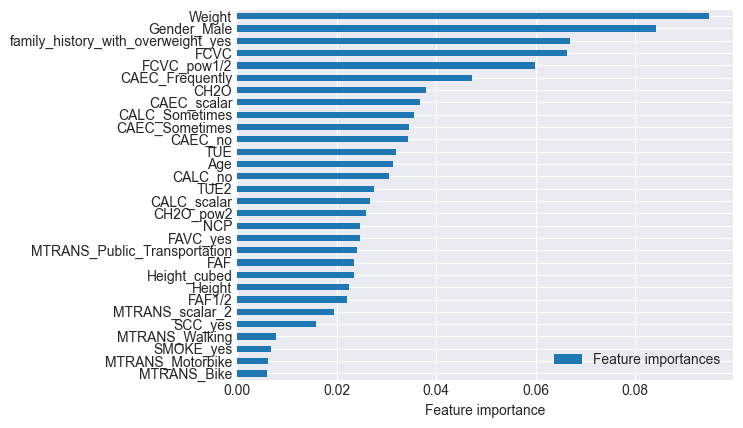

In [169]:
df_features = pd.DataFrame(clf.feature_importances_, index=new_X.columns, columns=['Feature importances'])
df_features = df_features.sort_values('Feature importances')

df_features.plot(kind='barh')
plt.grid()
plt.xlabel('Feature importance')
plt.show()

### tuned XGBoost together with cross-validation

In [160]:
def train_evaluate_model(X, y, new_X_test):
    # use Stratified KFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(X, y)

    scores = []
    predictions = []
    clfs = []

    for i, (train_index, val_index) in enumerate(skf.split(new_X, encoded_y)):
        print('Fitting with k-fold', i+1, 'out of', len(train_index))
        X_train = np.array(new_X)[train_index, :]
        y_train = np.array(encoded_y)[train_index]
        X_val = np.array(new_X)[val_index, :]
        y_val = np.array(encoded_y)[val_index]
        
        print('Training on', len(X_train), 'samples')
        print('Evaluating on', len(X_val), 'samples')
        
        clf = XGBClassifier(**best_params_xgb_optuna)
        clf.fit(X=X_train, y=y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)],
                early_stopping_rounds=10,
                verbose=50)
        
        
        y_pred_val = clf.predict(X_val)

        new_score = accuracy_score(y_val, y_pred_val)
        print('validation score is', new_score)
        scores.append(new_score)

        # store predictions
        y_pred_test_proba = clf.predict_proba(new_X_test)
        predictions.append(y_pred_test_proba)
        print('Round', i+1, 'Predictions stored successfully')
        
        clfs.append(clf)
        
    return scores, np.array(predictions), clfs

scores, predictions, clfs = train_evaluate_model(new_X, encoded_y, new_X_test)

Fitting with k-fold 1 out of 16606
Training on 16606 samples
Evaluating on 4152 samples


NameError: name 'best_params_xgb_optuna' is not defined

In [158]:
print('Average evaluation score = ', np.mean(scores))
y_test_pred = np.mean(predictions, axis=0)
y_test_pred = np.argmax(y_test_pred, axis=1)

df_submission['NObeyesdad'] = y_test_pred
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.to_csv('submission.csv', index=False)
# (previous simple model + height_weight_interation and height_cubed) Submition score: 0.91184
# (new model) Submition score: 

NameError: name 'scores' is not defined

###  using a voting classifier

In [223]:
clf_xgb = XGBClassifier(**best_params_XGB)
clf_gb = GradientBoostingClassifier()

voting_clf = VotingClassifier(estimators=[('xgb', clf_xgb), ('gb', clf_gb)], 
                              voting='soft')

voting_clf.fit(new_X, encoded_y)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8066785029706267,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.6571113285001668,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_...=None,
                                            learning_rate=0.1407018696033673,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None, min_child_weight=7,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=175, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [200]:
df_submission['NObeyesdad'] = voting_clf.predict(new_X_test)
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

df_submission

df_submission.to_csv('submission.csv', index=False)
# (previous simple model + height_weight_interation and height_cubed) Submition score: 0.91112
# (new model) Submition score: 

## 5.7 Gradient Boosting Classifier

In [224]:
# Initialize Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier(random_state=42)

# Define a grid of parameters to search over during tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Perform grid search: Use cross-validated grid search to find the best combination of parameters
grid_search_gb = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Get the best parameters and best score
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_
print("Best Parameters:", best_params_gb)
print("Best Score:", best_score_gb)


Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


KeyboardInterrupt: 

# 6. Choose the highest score above to submit